# Segundo parcial de **Series de Tiempo Univariadas**

## Integrantes

- Sofía Cuartas García   ——→ scuartasg@unal.edu.co —→ 1.000.874.937
- Simón Cuartas Rendón —→ scuartasr@unal.edu.co —→ 1.037.670.103


Un enlace al repositorio de GitHub empleado para poder crear este documento por parte de ambos integrantes del equipo se puede encontrar haciendo [clic aquí](https://github.com/scuartasr/ST_P2).

In [1]:
# Lectura de módulos importantes

# Módulos fundamentales para gráficos y trabajo con marcos de datos
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

# Módulos fundamentales para trabajos con series de tiempo

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Otros módulos importantes

from scipy.stats import kstest
plt.style.use('fivethirtyeight')

# Instalación del paquete pmdarima
# !pip install pmdarima               # Si no se tiene este módulo, se puede instalar con esta línea (descomentarla).
from pmdarima import auto_arima

In [2]:
# Módulo de trabajo actual

os.getcwd() 

'C:\\Users\\lenovo\\Documents\\2022-2\\ST\\Parciales\\ST_P2\\Cuadernos'

# <center><font size="10"><font color='red'>Serie de tiempo uno</font></center>

A continuación se presenta la solución de los ejercicios propuestos para la **serie de tiempo uno**. Así, se inicia realizando la lectura de los datos que se encuentran en la hoja denominada como *"serie1"* en el libro de Excel que contiene todos los datos que se van a emplear para este parcial. Para ello se va a comenzar leyendo los datos. Es importante tener en cuenta que estos se encuentran en una carpeta llamada **"Datos"**. A continuación, se realizará algunos chequeos básicos que permitan tener seguridad en cuanto a la correcta lectura de los datos.


In [3]:
st1 = pd.read_excel('../Datos/datos_parcial2.xlsx',
                    sheet_name = 'serie1',
                    parse_dates = ["fecha"])
st1.shape

(231, 2)

Esta base de datos contiene $231$ observaciones y $2$ columnas. Esto coincide con los registros que se tienen en el Excel. Luego, chequeando las primeras y las últimas cinco observaciones de la base de datos:

In [4]:
st1.head()

,fecha,valor
0,2021-01-01,0.06
1,2021-01-02,0.05
2,2021-01-03,0.05
3,2021-01-04,0.51
4,2021-01-05,2.03


In [5]:
st1.tail()

,fecha,valor
226,2021-08-15,16.90
227,2021-08-16,17.35
228,2021-08-17,18.85
229,2021-08-18,21.40
230,2021-08-19,22.60


No parece haber ningún inconveniente en la base de datos. Sin embargo, para tener certeza que los registros históricos están organizandos temporalmente (los más antiguos de primero), se procede con el ordenamiento:

In [6]:
st1.sort_values(by = "fecha", inplace = True)

Por último, se procede a verificar la tipología de los datos para las dos variables del marco de datos:

In [7]:
st1.dtypes

fecha    datetime64[ns]
valor           float64
dtype: object

Y en efecto, la columna ```fecha``` es de tipo ```datetime```, mientras que la columna ```valor``` ha sido leída por Python como de tipo numérica racional (flotante: ```float```). Por último, se reemplazan los índices secuenciales de la base de datos por las fechas como tal.

In [8]:
st1.set_index("fecha", inplace = True)

# <center><font size="5"><font color='blue'>Punto uno</font></center>
    
Realice los gráficos ACF y PACF para tratar de identificar los órdenes $p$, $d$ y $q$ del modelo $ARIMA(p, \ d, \ q)$. Saque conclusiones argumentando cada una.

Se va comenzar graficando la serie como tal y su ACF y PACF para identificar si la serie tiene componente estructural de tendencial, lo cual implicaría que se debe comenzar realizando una diferenciación para a continuación proceder adecuadamente con la identificación de los órdenes $p$ y $q$.

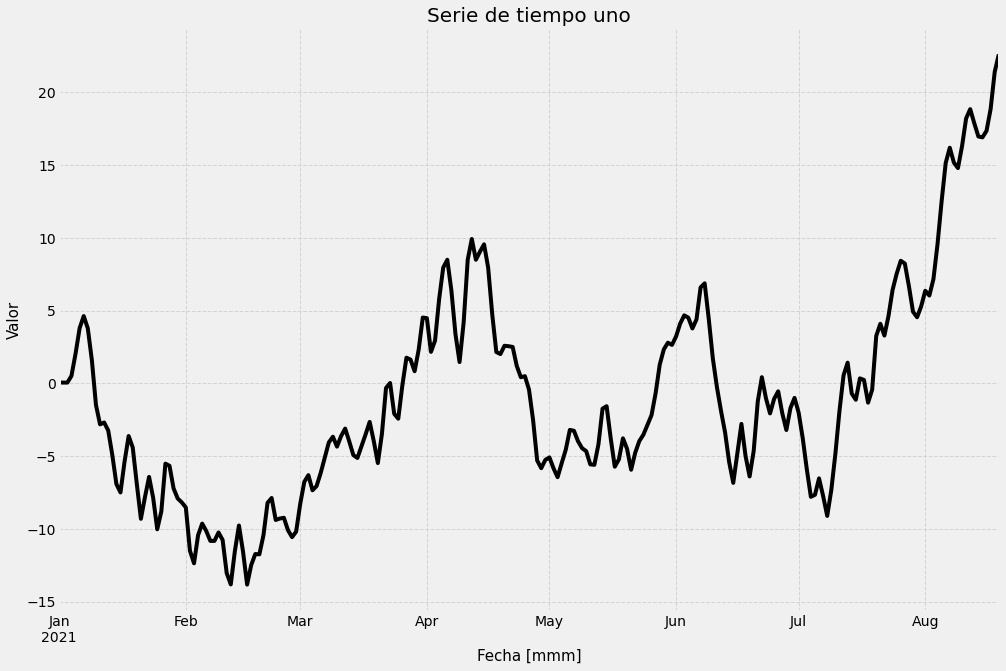

In [9]:
f1 = st1.plot(color = 'black',
              figsize = (15, 10))
plt.xlabel("Fecha [mmm]", fontsize = 15)
plt.ylabel("Valor", fontsize = 15)
plt.title("Serie de tiempo uno", fontsize = 20)
f1.get_legend().remove()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

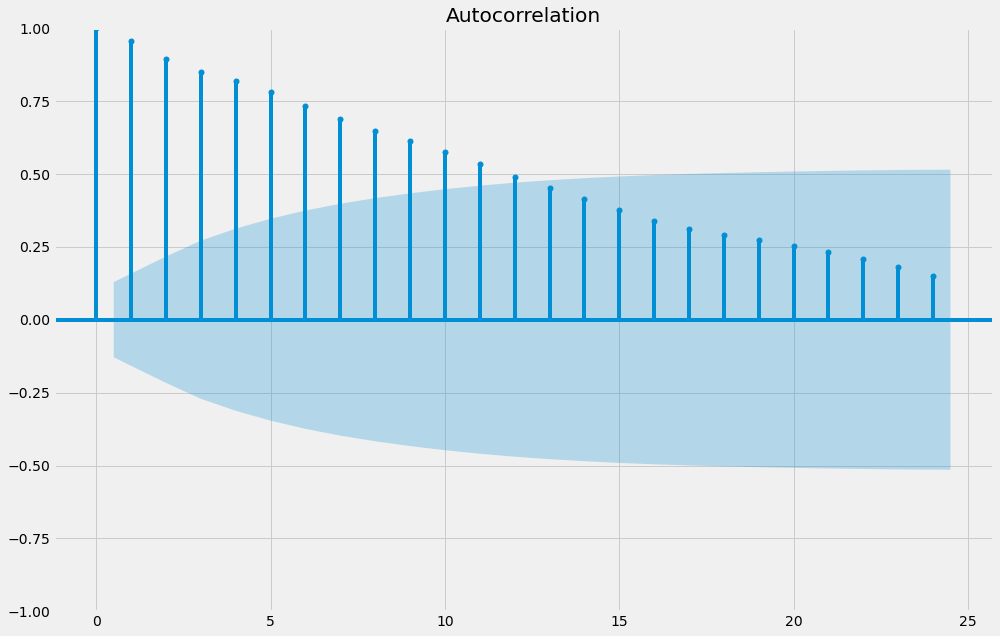

In [10]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st1)

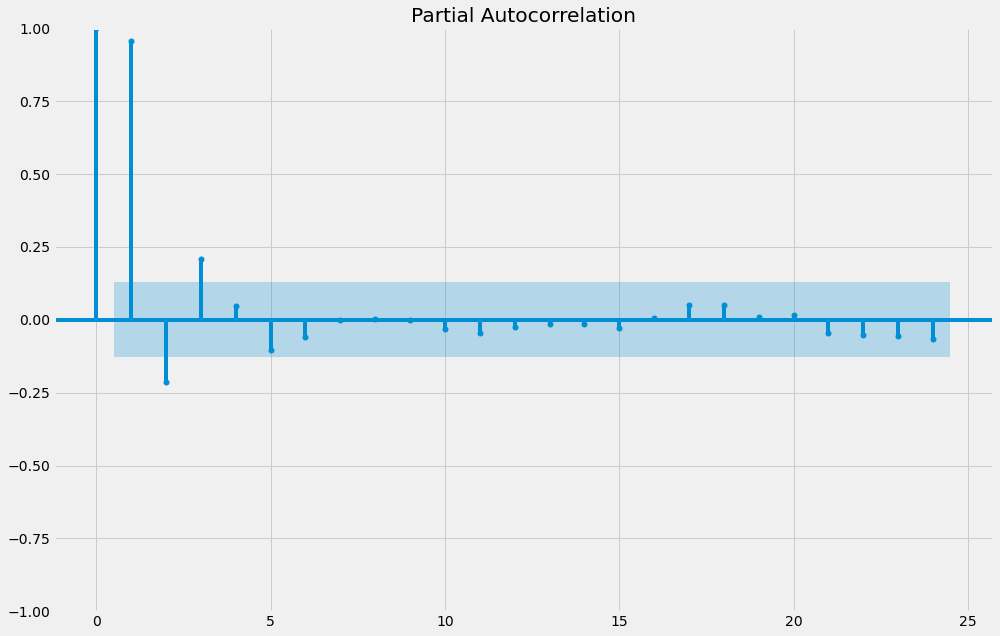

In [11]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st1, method = 'ywm')

A partir del gráfico de la serie de tiempo como tal es claro que esta no es estacionaria en tanto su media no es constante, y esto se refleja en su ACF en la medida en que esta decae lentamente a cero para rezagos mayores. Además, se observa que el patrón de la ACF es tipo cola no amortiguada (lo cual es concordante pues con la presencia de tendencia en la serie), y la PACF parece tener un patrón tipo corte, ya que el valor decrece de forma abrupta después de $\phi_{11}$; sin embargo, no es adecuado tratar de identificar los órdenes de $p$ y $q$ con estas ACF y PACF, ya que la serie no es estacionaria. Con esto, se sospecha que $d \geq 1$, esto es, de forma descriptiva se observa que podría ser necesario diferenciar la serie. Así, para tomar una decisión respecto a esto, se realizará el test de Dickey-Fuller para determinar si finalmente esto es necesario.

# <center><font size="5"><font color='blue'>Punto dos</font></center>
    
Aplicar la prueba de Dickey-Fuller para ver si es necesario tomar diferencias. Sacar conclusiones argumentando cada una.

A partir de los gráficos obtenidos en el punto anterior, se sospecha la presencia de raíces unitarias, haciendo invable de momento la selección de $p$ y $q$. Así pues, se va a verificar esto con un test de raíces unitarias de *Dickey-Fuller*, cuya **hipótesis nula** es que la serie tiene al menos una raíz unitaria y la **alternas** es que la serie no tiene raíces unitarias. Se usará un nivel de confianza de $\alpha = 0.05$. Estas hipótesis se pueden reexpresar como sigue:

$\left\lbrace\begin{array}{c}H_0: \phi = 1  \\ H_1: \phi < 1\end{array}\right. $ equivalentemente
$\left\lbrace\begin{array}{c} H_0: \textrm{El proceso no es estacionario} \\ H_1:\textrm{El proceso es estacionario.} \end{array}\right. $

In [12]:
# Cálculo del valor p asociado al test de Dickey-Fuller
adfuller(st1)[1] 

0.8482869409753937

Como se observa, para el test de Dickey-Fuller el valor p es $V_p = 0.84 > 0.05 = \alpha$, lo que implica que hay evidencia muestral suficiente para sugerir, con un nivel de significancia del cinco por ciento, que la serie de tiempo cuenta con raíces unitarias.

Con esto, se corrobora que se debe diferenciar la serie, de tal suerte que $d \geq 1$. Se comenzará pues con $d = 1$.

A continuación se calcula la serie diferenciada y se muestran las cinco primeras observaciones, permitiendo verificar que esta primera diferencia ha sido calculada de forma adecuada. 

In [13]:
st1d1 = st1.diff()
st1d1.head()

,valor
fecha,
2021-01-01,NaN
2021-01-02,-0.01
2021-01-03,0.00
2021-01-04,0.46
2021-01-05,1.52


Con esto, se procede graficando la serie diferenciada.

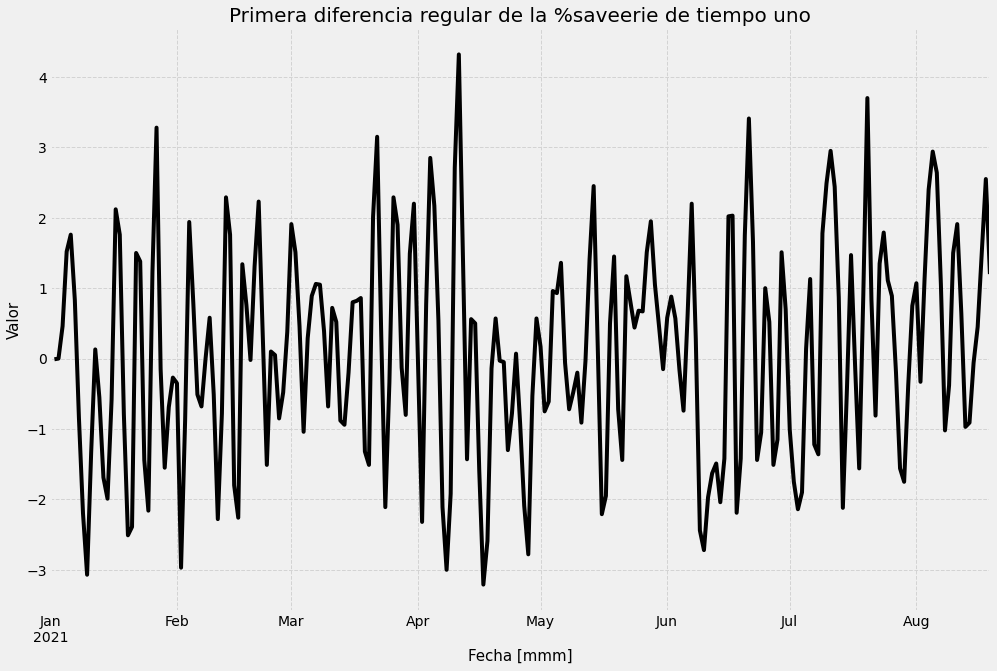

In [14]:
f1 = st1d1.plot(color = 'black',
              figsize = (15, 10))
plt.xlabel("Fecha [mmm]", fontsize = 15)
plt.ylabel("Valor", fontsize = 15)
plt.title("Primera diferencia regular de la %saveerie de tiempo uno", fontsize = 20)
f1.get_legend().remove()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

A partir del gráfico de la serie diferenciada, es razonable pensar que la serie puede ser estacionaria, ya que tiene media cero y su varianza es constante, además que no se presentan ciclos o rachas de signos positivos y negativos, quedando pues pendiente de verificar mediante la ACF y la PACF si se cumple la propiedad de ergodicidad que tienen las series estacionarias en covarianza (como se verificará en el siguiente punto). Ahora bien, para poder comprobar si la serie de tiempo es adecuada ahora para su modelamiento a través de un $ARIMA(p, \ d, \ q)$, se aplicará de nuevo un ***test de raíces unitarias de Dickey-Fuler*** con un nivel de significancia de $\alpha = 0.05$.

In [15]:
# Cálculo del valor p asociado al test de Dickey-Fuller
adfuller(st1d1[1: ])[1] 

1.2540124522200221e-09

Y se encuentra que $V_p \approx 1.25 \times 10 ^{-9} < 0.05 = \alpha$, lo que implica que la hipótesis nula debe ser rechazada. Así, no hay evidencia muestral suficiente para sugerir con un nivel de significancia del cinco por ciento que la serie tiene al menos una raíz unitaria. En la práctica, esto se interpreta como que la serie carece de raíces unitarias, y así se obtiene que la primera diferencia $d = 1$ es suficiente para poder modelar la serie.

# <center><font size="5"><font color='blue'>Punto tres</font></center>
    
Si $d \geq 1$ en el ítem $(2)$, entonces realizar de nuevo los gráficos ACF y PACF de la serie diferenciada de orden $d$ con el fin de identificar los órdenes $p$ y $q$. Sacar conclusiones argumentando cada una.

Enseguida se muestran los gráficos de la ACF y la PACF de la serie de tiempo diferenciada.

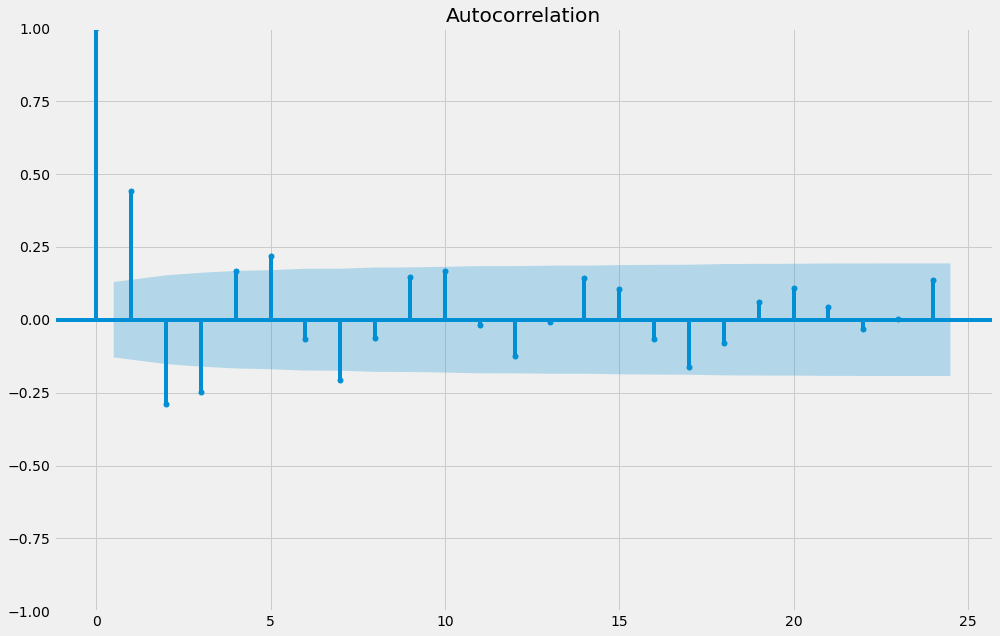

In [16]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st1d1[1:])
# Nótese que se toma los valores de la serie de tiempo diferenciada a partir de la segunda observación,
# ya que para la primera no se puede obtener su diferencia.

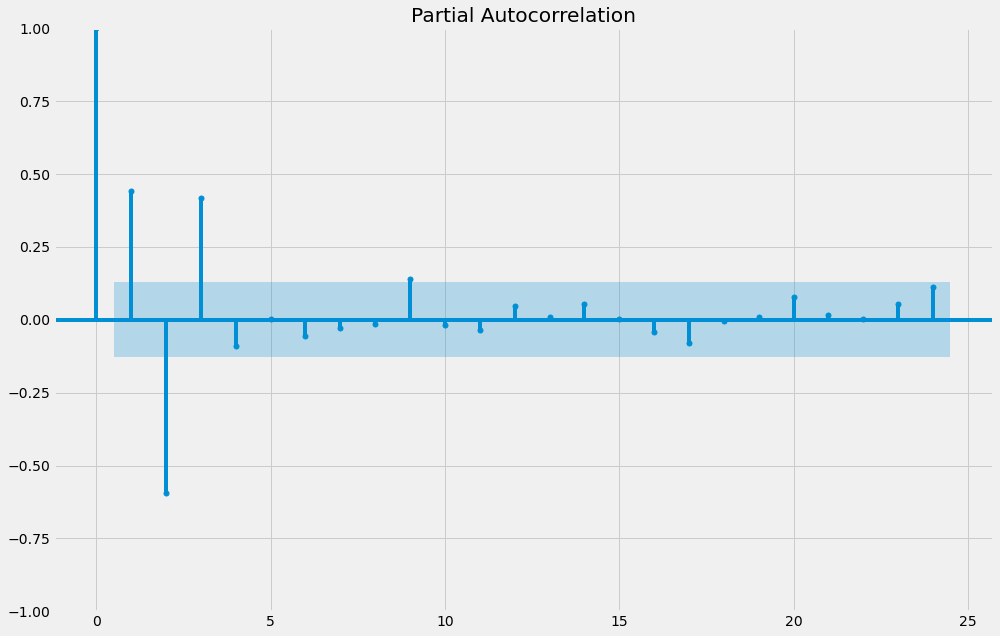

In [17]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st1d1[1:], method = 'ywm')

Se tiene que la ACF toma valores no significativos rápidamente (de acuerdo con las barras de *Bartlett*), es decir, para rezagos pequeños, lo que muestra que la serie es ergódica, cumplimiendo pues los tres requisitos básicos que debe cumplir una serie de tiempo para poder ser etiquetada como *estacionaria en sentido débil*. Así, es apropiado determinar los órdenes $p$ y $q$.

Se comienza, pues, considerando que la ACF tiene un patrón de cola exponencial amortiguada, mientras que la PACF exhibe un patrón tipo corte, lo cual implica que la serie diferenciada se debería modelar con un $AR(p)$, donde $p = 3$, ya que $\phi_{33}$ es el último valor de la PACF significativo. Con esto, se llega a que un modelo a considerar inicialmente es un $ARIMA(3, \ 1, \ 0)$.

# <center><font size="5"><font color='blue'>Punto cuatro</font></center>

Aplique varios modelos, explicando por qué aplica cada uno, y usar un criterio de selección para seleccionar el mejor. Sacar conclusiones argumentando cada una.
 
Sea $Y_t$ el valor de la serie de tiempo en un momento $t$. Para poder proceder con la estimación de los parámetros asociados a los modelos $ARIMA(p, \ d, \ q)$ que serán propuestos a continuación, entonces se van a 'resetear' los índices de la serie temporal en *Python*.

In [18]:
st1.reset_index(inplace = True)
st1

,fecha,valor
0,2021-01-01,0.06
1,2021-01-02,0.05
2,2021-01-03,0.05
3,2021-01-04,0.51
4,2021-01-05,2.03
...,...,...
226,2021-08-15,16.90
227,2021-08-16,17.35
228,2021-08-17,18.85
229,2021-08-18,21.40


In [19]:
st1.index = pd.DatetimeIndex(st1.fecha).to_period('D')
st1

,fecha,valor
fecha,,
2021-01-01,2021-01-01,0.06
2021-01-02,2021-01-02,0.05
2021-01-03,2021-01-03,0.05
2021-01-04,2021-01-04,0.51
2021-01-05,2021-01-05,2.03
...,...,...
2021-08-15,2021-08-15,16.90
2021-08-16,2021-08-16,17.35
2021-08-17,2021-08-17,18.85


### Modelo uno. $ARIMA(3, \ 1, \ 0)$

El primer modelo que se va a considerar es un $ARIMA(3, 1, 0)$, ya que anteriormente se encontró que la serie de tiempo diferenciada una vez se puede modelar mediante un $AR(3)$. Así, la ecuación del modelo es:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [20]:
mod11 = ARIMA(st1.valor, order = (3, 1, 0)).fit()
mod11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  231
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -324.862
Date:                Tue, 04 Oct 2022   AIC                            657.723
Time:                        14:57:55   BIC                            671.475
Sample:                    01-01-2021   HQIC                           663.270
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9507      0.059     16.213      0.000       0.836       1.066
ar.L2         -0.8858      0.065    -13.691      0.000      -1.013      -0.759
ar.L3          0.4167      0.060      6.920      0.000       0.299       0.535
sigma2         0.9800      0.103      9.481      0.000       0.777       1.183
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.56   Prob(JB):                         0.45
Heteroskedasticity (H):               1.21   Skew:                             0.07
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo dos. $ARIMA(2, \ 1, \ 0)$

Algún sujeto podría argumentar que el valor de $\hat{phi}_{22}$ se reduce de forma considerable en comparación con el valor de $\hat{\phi}_{33}$, por lo que la serie temporal con su primera diferencia se podría modelar mediante un $AR(2)$, llegando pues a un modelo $ARIMA(2, \ 1, \ 0)$. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2)(1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [21]:
mod12 = ARIMA(st1.valor, order = (2, 1, 0)).fit()
mod12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  231
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -346.804
Date:                Tue, 04 Oct 2022   AIC                            699.608
Time:                        14:57:56   BIC                            709.922
Sample:                    01-01-2021   HQIC                           703.768
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7020      0.051     13.650      0.000       0.601       0.803
ar.L2         -0.5939      0.056    -10.519      0.000      -0.705      -0.483
sigma2         1.1889      0.132      9.013      0.000       0.930       1.447
===================================================================================
Ljung-Box (L1) (Q):                  14.12   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.00   Prob(JB):                         0.18
Heteroskedasticity (H):               1.42   Skew:                             0.05
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo tres. $ARMA(3, \ 0)$

Si bien se mostró que para el modelamiento de esta serie temporal con modelos $ARIMA$ es necesario tomar la diferencia de la serie, se va a ensayar con un modelo $ARMA(3, \ 0)$, es decir, un modelo que ignora la primera diferencia y que toma el valor de $p = 3$ ya que la ACF tiene un patrón tipo cola (no amortiguada) y la PACF tiene un patrón tipo corte con $k = 3$, ya que $\hat{\phi}_{33}$ es el último valor de la PACF muestral que se puede considerar significativo y a continuación, en $\hat{\phi}_{44}$, hay una reducción abrupta. La ecuación de este modelo es:

$(1- \phi_1 B - \phi_2 B^2) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [22]:
mod13 = ARIMA(st1.valor, order = (3, 0, 0)).fit()
mod13.summary()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  231
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -350.240
Date:                Tue, 04 Oct 2022   AIC                            710.479
Time:                        14:57:56   BIC                            727.691
Sample:                    01-01-2021   HQIC                           717.422
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3879     11.061      0.487      0.626     -16.290      27.066
ar.L1          1.6970      0.052     32.838      0.000       1.596       1.798
ar.L2         -1.2919      0.094    -13.703      0.000      -1.477      -1.107
ar.L3          0.5888      0.058     10.228      0.000       0.476       0.702
sigma2         1.1855      0.132      8.948      0.000       0.926       1.445
===================================================================================
Ljung-Box (L1) (Q):                  14.87   Jarque-Bera (JB):                 3.20
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.45   Skew:                             0.05
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nótese que por la naturaleza no estacionaria de la serie de tiempo sin considerar ninguna diferencia, el módulo **```statsmodels```*** arroja una advertencia, indicando lo mal que podría resultar este modelo para ajustar la serie de tiempo ***serie1***.

### Modelo cuatro. $ARIMA(3, \ 1, \ 1)$

El modelo que a priori se puede considerar el mejor es el primero, y como se puede ver, se trata de un modelo autorregresivo para la serie temporal con su primera diferencia regular. Así, se van a considerar dos modelos $ARIMA$ con $q \neq 0$, y en este caso se toma el valor de $q = 1$, para evaluar si tal vez este modelo puede ajustar mejor la serie temporal. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = (1 + \theta_1 B) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [23]:
mod14 = ARIMA(st1.valor, order = (3, 1, 1)).fit()
mod14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  231
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -323.966
Date:                Tue, 04 Oct 2022   AIC                            657.931
Time:                        14:57:56   BIC                            675.122
Sample:                    01-01-2021   HQIC                           664.866
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7789      0.147      5.306      0.000       0.491       1.067
ar.L2         -0.7655      0.115     -6.629      0.000      -0.992      -0.539
ar.L3          0.3144      0.106      2.966      0.003       0.107       0.522
ma.L1          0.2099      0.155      1.352      0.176      -0.094       0.514
sigma2         0.9723      0.102      9.557      0.000       0.773       1.172
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.99   Prob(JB):                         0.48
Heteroskedasticity (H):               1.18   Skew:                             0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo cinco. $ARIMA(3, \ 1, \ 2)$

El modelo que a priori se puede considerar el mejor es el primero, y como se puede ver, se trata de un modelo autorregresivo para la serie temporal con su primera diferencia regular. Así, se van a considerar dos modelos $ARIMA$ con $q \neq 0$, y en este caso se toma el valor de $q = 2$, para evaluar si tal vez este modelo puede ajustar mejor la serie temporal. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = (1 + \theta_1 B + \theta_2 B^2) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [24]:
mod15 = ARIMA(st1.valor, order = (3, 1, 2)).fit()
mod15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  231
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -323.965
Date:                Tue, 04 Oct 2022   AIC                            659.930
Time:                        14:57:56   BIC                            680.559
Sample:                    01-01-2021   HQIC                           668.252
                         - 08-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7866      0.322      2.440      0.015       0.155       1.418
ar.L2         -0.7678      0.148     -5.171      0.000      -1.059      -0.477
ar.L3          0.3177      0.162      1.956      0.050      -0.001       0.636
ma.L1          0.2021      0.331      0.611      0.541      -0.446       0.850
ma.L2         -0.0058      0.214     -0.027      0.978      -0.425       0.413
sigma2         0.9723      0.102      9.542      0.000       0.773       1.172
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.99   Prob(JB):                         0.48
Heteroskedasticity (H):               1.18   Skew:                             0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Resumen de resultados

Ahora, basados en la calidad de los ajustes realizados por los cinco modelos presentados, se va a determinar cuál modelo es más adecuado basados en las métricas asociadas al ajuste, las cuales se presentan en la siguiente tabla:

|Modelo|Logverosimilitud|AIC|BIC|
|------|----------------|---|---|
| Uno | -324.862 | <span style="background-color: #FFFF00">**657.723**</span> | 671.475 |
| Dos | -346.804 | 699.608 | 709.922 |
| Tres | -350.240 | 710.479 | 727.691 |
| Cuatro | -323.966 | 657.931 | 675.122 | 
| Cinco | <span style="background-color: #FFFF00">**-323.965**</span> | 659.930 | <span style="background-color: #FFFF00">**668.252**</span> |

Así pues, un modelo realiza un mejor ajuste cuando su logverosimilitud se maximiza o cuando sus criterios de información bayesiano o de Akaike se minimizan, y como se puede ver, el modelo ***cinco*** es el que consigue la máxima logverosimilitud y el mínimo BIC, toda vez que el modelo ***uno*** logra el mínimo AIC. Con esto, se puede pensar que el modelo que mejores ajustes realiza es el cinco, sin embargo, es importante notar que la diferencia entre las logverosimilitudes y los BIC de ambos modelos no es considerable (menos de una unidad para la logverosimilitud y menos de tres unidades para el BIC), mientras que con el AIC, el modelo ***uno*** aventaja al ***cinco*** por casi dos unidades; además, no hay que perder de vista que el modelo ***uno*** es más parsimonioso que el ***cinco***, ya que este último debe estimar dos parámetros más en comparación con el primero. En este orden de ideas, se considerará que el modelo más adecuado es el modelo ***uno***, coincidiendo pues con el análisis realizado antes con la ACF y la PACF muestrales de la serie de tiempo con su primera diferencia regular.

Así las cosas, el modelo que se va a emplear en adelante es el que se muestra en la siguiente ecuación:

$$(1 - 0.9507 B + 0.8858 B ^2 - 0.4167 B ^3)(1 - B) Y_t = w_t$$

# <center><font size="5"><font color='blue'>Punto cinco</font></center>
    
Verificar si el mejor modelo seleccionado en el numeral cuatro es estacionario e invertible.

Es importante recordar inicialmente que, de acuerdo con la teoría de las serie de tiempo y los modelos $ARIMA$, los modelos $AR(p)$ siempre son invertibles y los modelos $MA(q)$ son siempre, por su parte, estacionarios. Así las cosas, teniendo en cuenta que el modelo ***uno*** se puede considerar como un $AR(3)$ para la serie temporal a la que se le toma la primera diferencia regular, entonces se puede afirmar que este cumple con la condición de ser **invertible**, quedando pendiente verificar si el modelo ajustado es estacionario. Para ello, se debe cumplir que el módulo de las raíces de $\phi_3 (B)$ estén por fuera del círculo unitario. Observar pues que:

$$\hat{\phi}_3 (B) = 1 - 0.9507 B + 0.8858 B ^2 - 0.4167 B ^3$$

Para el cálculo de las ráices y sus módulos se emplean las funciones ```abs``` y ```np.roots``` de *Python*.

In [25]:
coefs11 = [-0.4167, 0.8858, -0.9507, 1]
modulos11 = abs(np.roots(coefs11))
modulos11

array([1.6294354 , 1.21358354, 1.21358354])

In [26]:
modulos11 > 1

array([ True,  True,  True])

Como se puede ver, las tres raíces del polinomio $\hat{\phi}_3 (B)$ son mayores que uno, por lo que se cumple que este modelo no solo es invertible, sino que también es estacionario. Ahora bien, esto último se puede chequear gráficamente observando los gráficos diagnósticos que entrega *Python*.

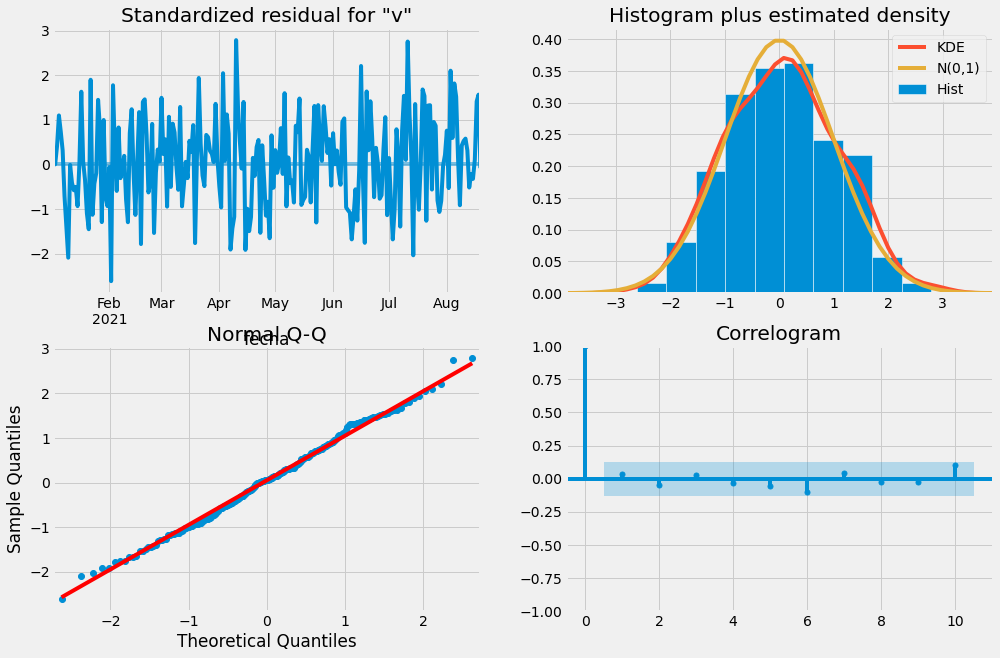

In [27]:
f3 = mod11.plot_diagnostics(figsize = (15, 10))

Como se puede observar en el gráfico de la primera fila a la izquierda, los residuales oscilan alrededor de cero, por lo que se puede decir que son estacionarios en covarianza. Asimismo, se observa que dichas oscilaciones se dan en un rango homogéneo (entre dos y dos negativo aproximadamente), lo que evidencia gráficamente que se puede cumplir el supuesto de homocedasticidad. Luego, pasando al gráfico de la primera fila a la derecha, se tiene que los residuales se distribuye alrededor de cero y que son mesocúrticos, lo cual se refleja en la semejanza que tiene la línea de densidad empírica (KDE) con la de una distribución normal con media cero y varianza uno (N(0, 1)), respaldando los supuestos de media nula y homocedasticidad que se discutieron antes.

Por último, se tiene que en la gráfica de la derecha de la segunda fila, que es la ACF para los residuales, se puede considerar que los residuales son ergódicos. Esto se discutirá con más detalles en el siguiente numeral, y así, se tiene que se puede pensar que los errores son estacionarios en sentido débil, corroborando lo que se mostró recientemente de forma analítica con los módulos de las raíces del polinomio $\hat{\phi}_3 (B)$.

# <center><font size="5"><font color='blue'>Punto seis</font></center>
    
Verificar si existe autocorrelación en los residuales del modelo usando el gráfico ACF y con la prueba de Ljung-Box para los diez primeros rezagos.

### Gráfico de la ACF para los residuales del modelo uno

A continuación se va a realizar el valor de los residuales así:

$$\hat{w}_t = Y_t - \hat{Y}_t, \ \ \ t = 1, \ 2, \ \dots, 231$$

In [28]:
# Cálculo de los residuales

residuales11 = st1.valor - mod11.fittedvalues
residuales11

fecha
2021-01-01    0.060000
2021-01-02   -0.010000
2021-01-03    0.004419
2021-01-04    0.454074
2021-01-05    1.086834
                ...   
2021-08-15   -0.320807
2021-08-16    0.105142
2021-08-17    1.398236
2021-08-18    1.547545
2021-08-19   -0.083106
Freq: D, Length: 231, dtype: float64

Y con esto se puede proceder con la construcción del gráfico de la ACF de estos residuales.

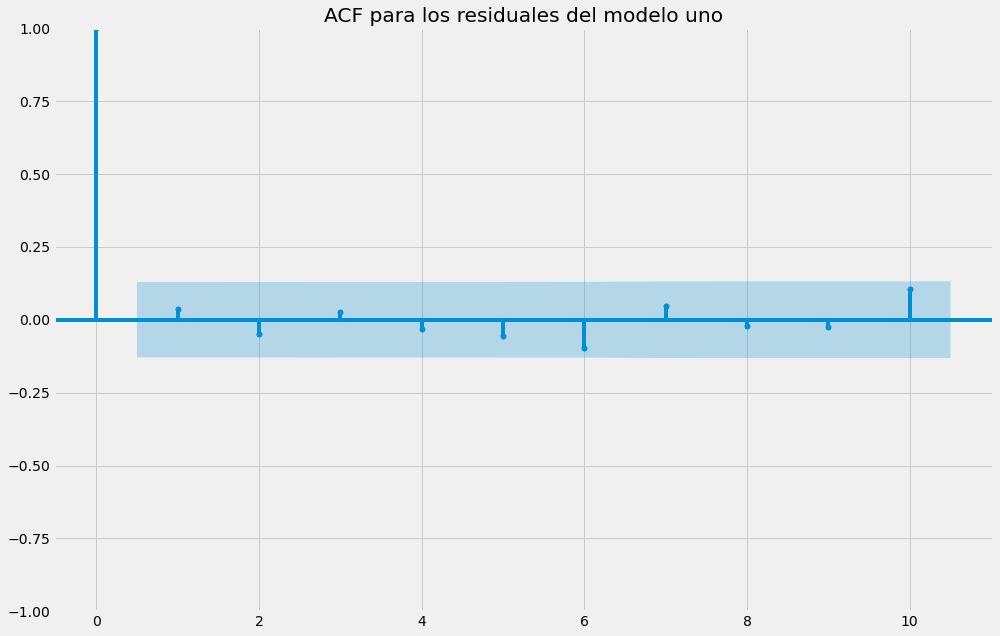

In [29]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     f2 = plot_acf(residuales11, lags = 10, title = "ACF para los residuales del modelo uno")

Como se puede observar, los $\hat{\rho} (k), \  k = 1, \ \dots, \ 10$ no superan las barras de *Bartlett*, por lo que se consideran no significativos. Esto es positivo en el sentido que no aportan sospechas sobre problemas de autocorrelación con los residuales, teniendo en cuenta que se asume que los errores son un ruido blanco, lo cual implica que son incorrelacionados entre sí. Ahora bien, se procederá a verificar esto con un test.

### Test de Ljung-Box

Sea $\rho (k) = Corr(w_t, \ w_{t+k})$. Con el test de Ljung-Box se puede verificar que los errores estén incorrelacionados a través de los residuales del modelo ***uno***, para lo cual se tienen las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \rho(1) = \rho(2) = \cdots = \rho(m) = 0 \\
        H_1: \ \exists \ k \ | \ \rho(k) \neq 0, \ k = 6, 12, 18, 24, 30, 36
\end{cases}
$$

La estadística de prueba para este test es $Q_{LB} = n \times (n+2) \sum_{k = 1}^m \frac{[\hat{\rho} (k)]^2}{239 - k}$, donde $n = 231$ en este caso y se tiene que bajo la hipótesis nula $Q_{LB} \ \sim \ \chi^2 (m)$. Para este test es posible obtener un valor p como: $V_p = \mathbb{Pr} [\chi^2 (m) > Q_{LB} ]$. Así:

In [30]:
sm.stats.acorr_ljungbox(residuales11,
                        lags = [6, 9, 12, 18, 24, 30, 36],
                        return_df = True)

,lb_stat,lb_pvalue
6,4.308090,0.635060
9,5.082444,0.827063
12,7.860799,0.795912
18,11.293854,0.881473
24,14.811524,0.926153
30,31.586809,0.386987
36,39.353079,0.322183


Nótese pues que de acuerdo con el test de Ljung-Box para rezagos correspondientes a los primeros seis múltiplos de seis, en todos ellos sucede que $V_p > \alpha = 0.05$. Con esto, se concluye que hay evidencia muestral suficiente para sugerir que los errores son incorrelacionados. Para normalidad, como se chequeará a continuación, esto implica que los errores son independientes entre sí.

Es importante notar que el test de Ljung-Box concuerda con el análisis gráfico de la función de autocorrelación muestral. Además, en el resumen que entrega *Python* cuando se encuentra el modelo, se da $V_p = 0.56 > 0.05$, concordando con lo calculado de forma 'manual' con la función ```acorr_ljungbox``` para los diferentes valores $m$ especificados antes.

# <center><font size="5"><font color='blue'>Punto siete</font></center>

Verificar si hay normalidad en los residuales del modelo. Sacar conclusiones argumentando cada una de ellas.

Se supuso, cuando se ajustaron los distintos modelos, que los errores del modelo son un ruido blanco gaussiano, por lo que ahora se procederá a verificar con ayuda de los residuales si se puede considerar estadísticamente que los errores, en efecto, son normales. Así pues, se consideran las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \text{Los errores se distribuyen siguiendo una normal} \\
        H_1: \ \text{Los errores no se distribuyen siguiendo una normal}
\end{cases}
$$

Para esto, se van a usar los tests analíticos de Kolmogorov-Smirnov (ya que $n = 231 > 50$) y de Jaque-Bera con un nivel de significancia de $\alpha = 0.05$, así como análisis gráficos. Así, comenzando con el test KS:

In [31]:
kstest(residuales11, 'norm')

KstestResult(statistic=0.046544876424044646, pvalue=0.6810241901825249)

Nótese que el valor p de la prueba es $V_p = 0.68 > 0.05 = \alpha$, por lo que hay evidencia muestral suficiente para sugerir que los errores se distribuyen siguiendo una normal, con un nivel de significancia del cinco por ciento. De igual forma, con el resumen entregado por *Python*, se obtiene que el valor p del test JB es $V_p = 0.45 > \alpha$, derivando la misma conclusión que el test KS.

Ahora bien, en cuanto a la prueba gráfica, en el gráfico del numeral cinco, en la segunda fila a la izquierda, se tiene un gráfico cuantil-cuantil para los residuales, y en dicha figura se encuentra que los residuales no tienen desviaciones significativas respecto a los cuantiles teóricos, resultando razonable considerar que los errores siguen una distribución normal.

# <center><font size="5"><font color='blue'>Punto ocho</font></center>
    
Si todo lo anterior se cumple, entonces se puede realizar pronósticos con el 'mejor' modelo ajustado para los cinco valores futuros. Sacar conclusiones argumentando cada una.

Para el ajuste de modelos autorregresivos integrados de medias móviles se supone que los errores estructurales son un ruido blanco gaussiano, lo cual implica que estos son independientes e idénticamente distribuidos siguiendo una normal de media cero y varianza constante. Así pues, se encontró que para el modelo uno, un $ARIMA(3, \ 1, \ 0)$, los errores son un proceso estacionario en convarianza, independientes y se distribuye siguiendo una normal alrededor de cero, por lo que su media en efecto es nula y a su vez son homocedásticos. Además, como el modelo es un $AR(3)$ para la primera diferencia regular, este es invertible y por tanto es adecuado realizar predicciones con este modelo, y así mismo, se encontró que se cumple el supuesto de estacionariedad en covarianza.

Con esto, se procede a obtener estimaciones puntuales y con intervalos de confianza al 95 % para los siguientes cinco días.

In [32]:
pronostico11 = mod11.get_prediction(start = '2021-08-20',
                                    end = '2021-08-24',
                                    dynamic = False)
pron_puntual11 = pronostico11.predicted_mean
pron_ci11 = pronostico11.conf_int(alpha = 0.05) 
estims11 = pd.concat([pron_ci11, pron_puntual11], axis = 1)
est11 = estims11.rename(columns = {"lower valor": "IC, extremo inferior",
                           "upper valor": "IC, extremo superior",
                           "predicted_mean": "Estimación puntual"})
round(est11, 2)

,"IC, extremo inferior","IC, extremo superior",Estimación puntual
2021-08-20,20.17,24.05,22.11
2021-08-21,17.38,25.89,21.64
2021-08-22,16.41,27.85,22.13
2021-08-23,16.34,29.27,22.81
2021-08-24,15.68,29.95,22.82


Gráficamente, se observa de la siguiente manera:

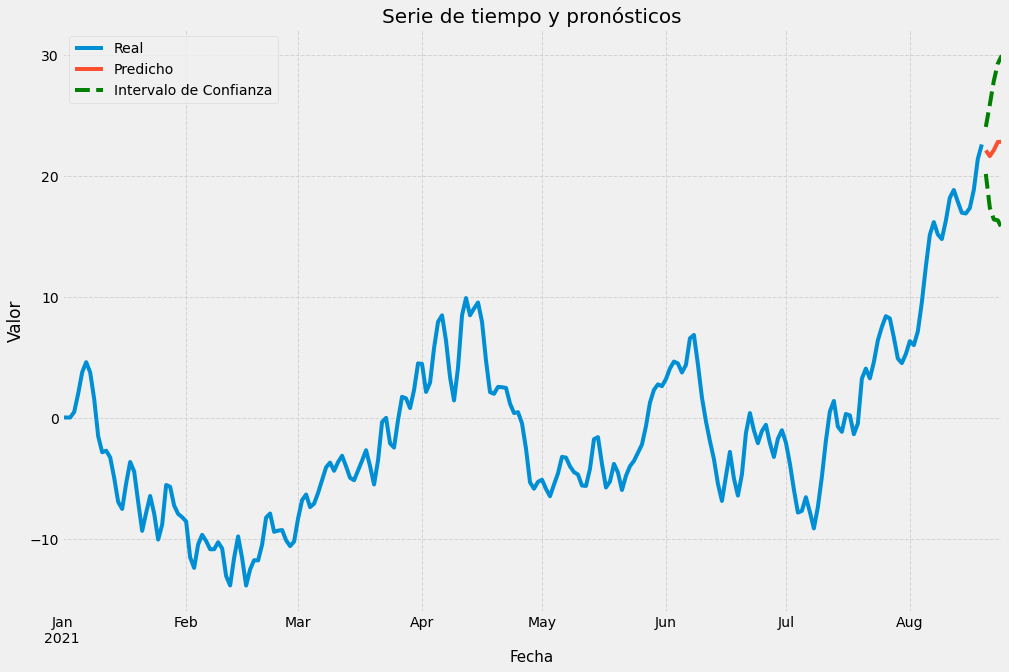

In [33]:
plt.figure(figsize=(15, 10))  #  Graficamos:
st1.valor.plot()
plt.title("Serie de tiempo y pronósticos", fontsize = 20)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Valor')
pronostico11.predicted_mean.plot()
pron_ci11.iloc[:,0].plot(color="green", linestyle = '--')
pron_ci11.iloc[:,1].plot(color="green", linestyle = '--')
plt.legend(["Real", "Predicho", "Intervalo de Confianza"])
plt.grid(color = 'lightgray', linestyle = '--')

# <center><font size="10"><font color='red'>Serie de tiempo dos</font></center>

A continuación se presenta la solución de los ejercicios propuestos para la **serie de tiempo dos**. Así, se inicia realizando la lectura de los datos que se encuentran en la hoja denominada como *"datos2"* en el libro de Excel que contiene todos los datos que se van a emplear para este parcial. Para ello se va a comenzar leyendo los datos. Es importante tener en cuenta que estos se encuentran en una carpeta llamada **"Datos"**. A continuación, se realizará algunos chequeos básicos que permitan tener seguridad en cuanto a la correcta lectura de los datos.


In [34]:
st2 = pd.read_excel('../Datos/datos_parcial2.xlsx',
                    sheet_name = 'datos2',
                    parse_dates = ["date"])
st2.shape

(521, 2)

Esta base de datos contiene $521$ observaciones y $2$ columnas. Esto coincide con los registros que se tienen en el Excel. Luego, chequeando las primeras y las últimas cinco observaciones de la base de datos:

In [35]:
st2.head()

,date,value
0,2020-01-01,-0.89
1,2020-01-02,-0.99
2,2020-01-03,-1.62
3,2020-01-04,-1.13
4,2020-01-05,-0.91


In [36]:
st2.tail()

,date,value
516,2021-05-31,-92.78
517,2021-06-01,-91.90
518,2021-06-02,-92.96
519,2021-06-03,-92.96
520,2021-06-04,-94.24


No parece haber ningún inconveniente en la base de datos. Además, nótese que los registros son diarios desde el primero de enero del 2020 hasta el cuatro de junio de 2021 inclusive, por lo que si se tiene en cuenta que durante estas dos fechas hay 521 días, entonces en efecto se tiene un registro por día de acuerdo con las dimensiones de la base de datos.

Ahora bien, para tener certeza que los registros históricos están organizandos temporalmente (los más antiguos de primero), se procede con el ordenamiento:

In [37]:
st2.sort_values(by = "date", inplace = True)

Por último, se procede a verificar la tipología de los datos para las dos variables del marco de datos:

In [38]:
st2.dtypes

date     datetime64[ns]
value           float64
dtype: object

Y en efecto, la columna ```date``` es de tipo ```datetime```, mientras que la columna ```value``` ha sido leída por Python como de tipo numérica racional (flotante: ```float```). Por último, se reemplazan los índices secuenciales de la base de datos por las fechas como tal.

In [39]:
st2.set_index("date", inplace = True)
st2.head()

,value
date,
2020-01-01,-0.89
2020-01-02,-0.99
2020-01-03,-1.62
2020-01-04,-1.13
2020-01-05,-0.91


# <center><font size="5"><font color='blue'>Punto uno</font></center>
    
Realice los gráficos ACF y PACF para tratar de identificar los órdenes $p$, $d$ y $q$ del modelo $ARIMA(p, \ d, \ q)$. Saque conclusiones argumentando cada una.

Se va comenzar graficando la serie como tal y su ACF y PACF para identificar si la serie tiene componente estructural de tendencial, lo cual implicaría que se debe comenzar realizando una diferenciación para a continuación proceder adecuadamente con la identificación de los órdenes $p$ y $q$.

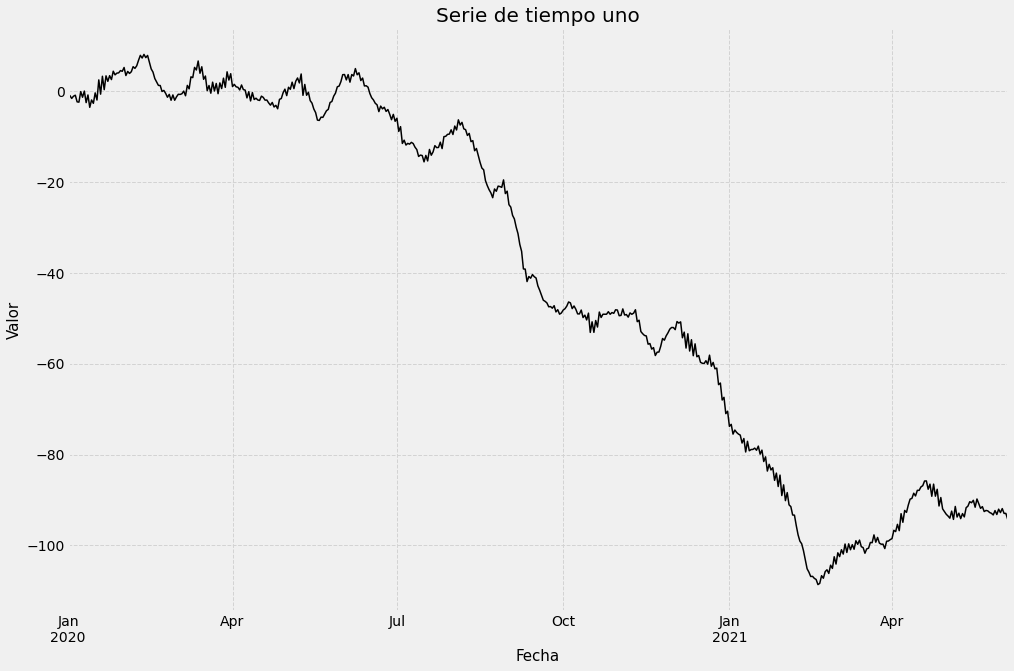

In [40]:
f1 = st2.plot(color = 'black',
              figsize = (15, 10),
              linewidth = 1.5)
plt.xlabel("Fecha", fontsize = 15)
plt.ylabel("Valor", fontsize = 15)
plt.title("Serie de tiempo uno", fontsize = 20)
f1.get_legend().remove()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

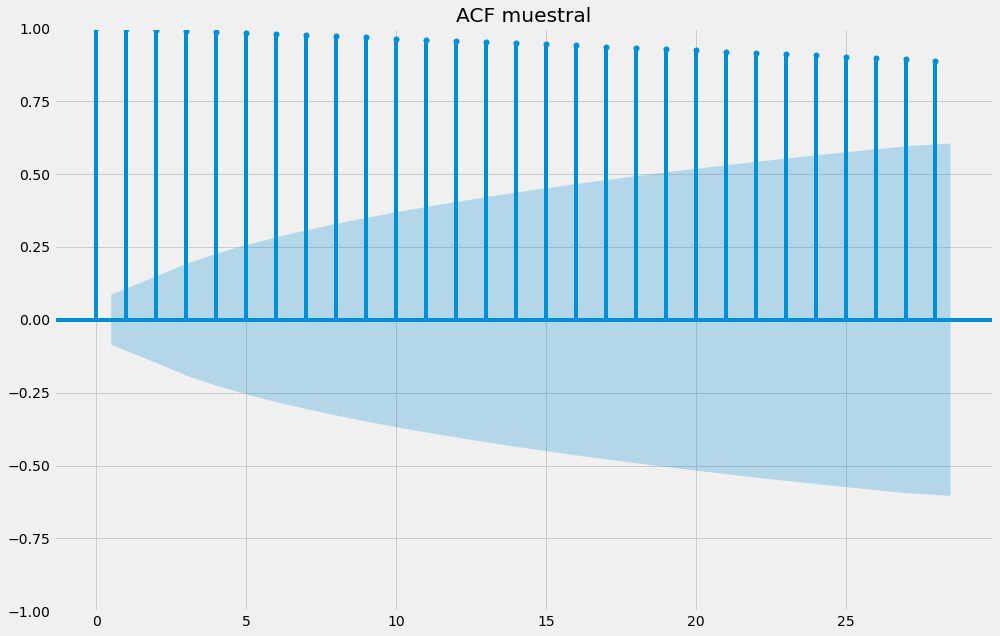

In [41]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st2,
              title = "ACF muestral")

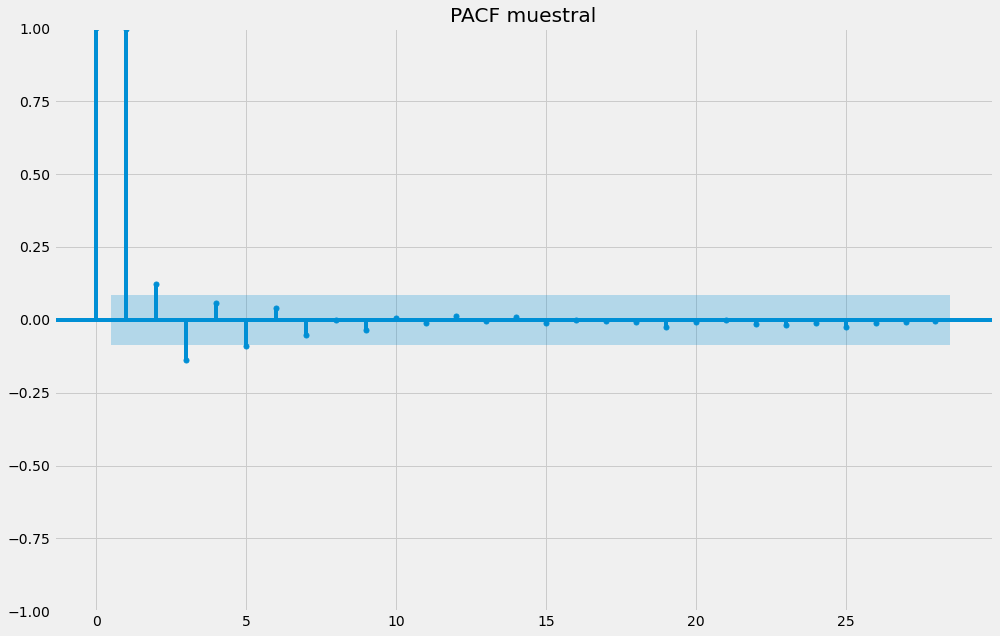

In [42]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st2, method = 'ywm',
               title = "PACF muestral")

A partir de los gráficos anteriores, vale la pena comenzar mencionado que la serie de tiempo **no es estacionaria**, ya que su media no es constante, reflejándose esto en una tendencia negativa en la serie desde enero 01 de 2020 hasta mediados de febrero, teniendo un breve repunte a partir de entonces. Esta no estacionariedad se refleja, pues, en el gráfico de la ACF muestral, ya que tiene un patrón de cola positiva no amortiguada, lo que significa que las autocorrelaciones decaen muy lentamente a medida que el rezago aumenta, lo cual indica que no se cumple la propiedad de ergodicidad que deben tener las series temporales estacionarias en sentido débil, y por tanto, se debe diferenciar la serie, de forma que $d \geq 1$.

No obstante, la varianza de la serie temporal parece ser constante, lo cual hace innecesaria la introducción de logaritmos u otra clase de transformaciones para estabilizarla.

En cuanto a la PACF, se tiene que esta muestra un decaimiento abrupto después de $\hat{\phi}_{11}$, pero se tiene que este estimador, junto con $\hat{\phi}_{22}$ y $\hat{\phi}_{33}$ son estadísticamente significativos al superar las barras de *Bartlett*. Sin embargo, teniendo en cuenta que la serie aún no estacionaria, entonces de momento no es adecuado proponer valores para $p$ y $q$.

# <center><font size="5"><font color='blue'>Punto dos</font></center>
    
Aplicar la prueba de Dickey-Fuller para ver si es necesario tomar diferencias. Sacar conclusiones argumentando cada una.

A partir de los gráficos obtenidos en el punto anterior, se sospecha la presencia de raíces unitarias, haciendo invable de momento la selección de $p$ y $q$. Así pues, se va a verificar esto con un test de raíces unitarias de *Dickey-Fuller*, cuya **hipótesis nula** es que la serie tiene al menos una raíz unitaria y la **alternas** es que la serie no tiene raíces unitarias. Se usará un nivel de confianza de $\alpha = 0.05$. Estas hipótesis se pueden reexpresar como sigue:

$\left\lbrace\begin{array}{c}H_0: \phi = 1  \\ H_1: \phi < 1\end{array}\right. $ equivalentemente
$\left\lbrace\begin{array}{c} H_0: \textrm{El proceso no es estacionario} \\ H_1:\textrm{El proceso es estacionario.} \end{array}\right. $

In [43]:
# Cálculo del valor p asociado al test de Dickey-Fuller
adfuller(st2)[1] 

0.940537950308511

Como se observa, para el test de Dickey-Fuller el valor p es $V_p = 0.94 > 0.05 = \alpha$, lo que implica que hay evidencia muestral suficiente para sugerir, con un nivel de significancia del cinco por ciento, que la serie de tiempo cuenta con raíces unitarias.

Con esto, se corrobora que se debe diferenciar la serie, de tal suerte que $d \geq 1$. Se comenzará pues con $d = 1$.

A continuación se calcula la serie diferenciada y se muestran las cinco primeras observaciones, permitiendo verificar que esta primera diferencia ha sido calculada de forma adecuada. 

In [44]:
st2d1 = st2.diff()
st2d1.head()

,value
date,
2020-01-01,NaN
2020-01-02,-0.10
2020-01-03,-0.63
2020-01-04,0.49
2020-01-05,0.22


Con esto, se procede graficando la serie diferenciada, así como los gráficos de sus funciones de autocorrelación y autocorrelación parcial.

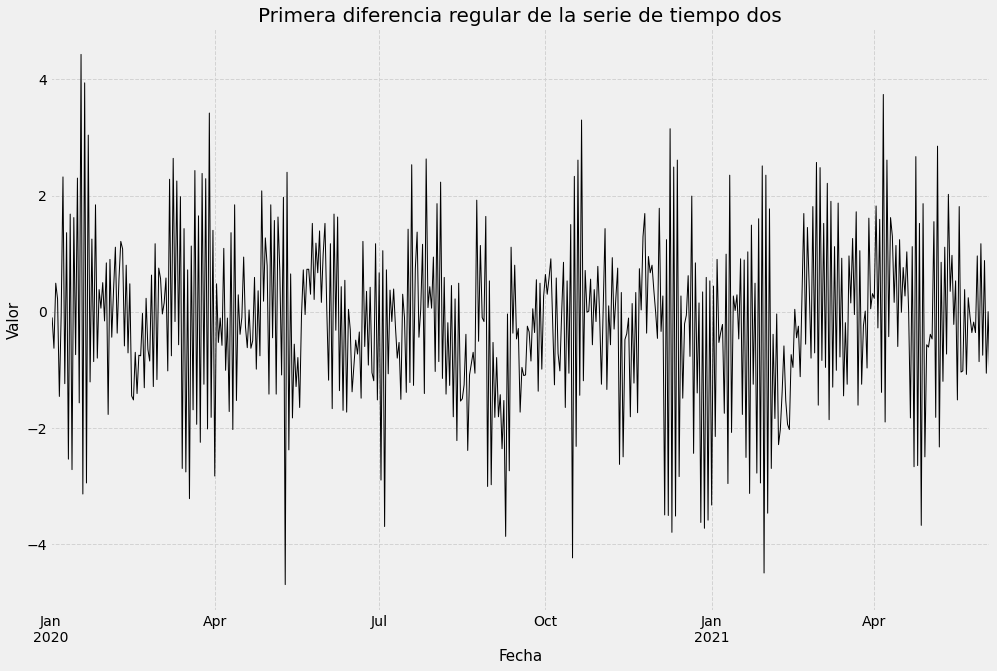

In [45]:
f1 = st2d1.plot(color = 'black',
              figsize = (15, 10),
                linewidth = 1)
plt.xlabel("Fecha", fontsize = 15)
plt.ylabel("Valor", fontsize = 15)
plt.title("Primera diferencia regular de la serie de tiempo dos", fontsize = 20)
f1.get_legend().remove()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

Como se observa, la primera serie temporal de la serie parece tener media nula, ya que los valores de esta oscilan alrededor de cero. Además, no se observan desvaciones particularmente grandes o pequeñas en algún periodo de tiempo específico, por lo que se puede pensar que esta serie es homocedástica, y así, solo quedaría pendiente de verificar la propiedad de ergodicidad para que se pueda afirmar con la evidencia gráfica que la serie es estacionaria en sentido débil (esto se desarrollará en el siguiente numeral). De momento, se apelará el test analítico de *Dickey-Fuller* nuevamente, con un nivel de significancia del cinco por ciento, para determinar si la primera diferencia regular de la serie original es estacionaria es suficiente para poder modelarla a través de un $ARIMA$:

In [46]:
# Cálculo del valor p asociado al test de Dickey-Fuller
adfuller(st2d1[1: ])[1] 

3.7249928567284016e-11

Y se encuentra que $V_p \approx 3.72 \times 10 ^{-11} < 0.05 = \alpha$, lo que implica que la hipótesis nula debe ser rechazada. Así, no hay evidencia muestral suficiente para sugerir con un nivel de significancia del cinco por ciento que la serie tiene al menos una raíz unitaria. En la práctica, esto se interpreta como que la serie carece de raíces unitarias, y así se obtiene que la primera diferencia $d = 1$ es suficiente para poder modelar la serie.

# <center><font size="5"><font color='blue'>Punto tres</font></center>
    
Si $d \geq 1$ en el ítem $(2)$, entonces realizar de nuevo los gráficos ACF y PACF de la serie diferenciada de orden $d$ con el fin de identificar los órdenes $p$ y $q$. Sacar conclusiones argumentando cada una.

Enseguida se muestran los gráficos de la ACF y la PACF de la serie de tiempo diferenciada.

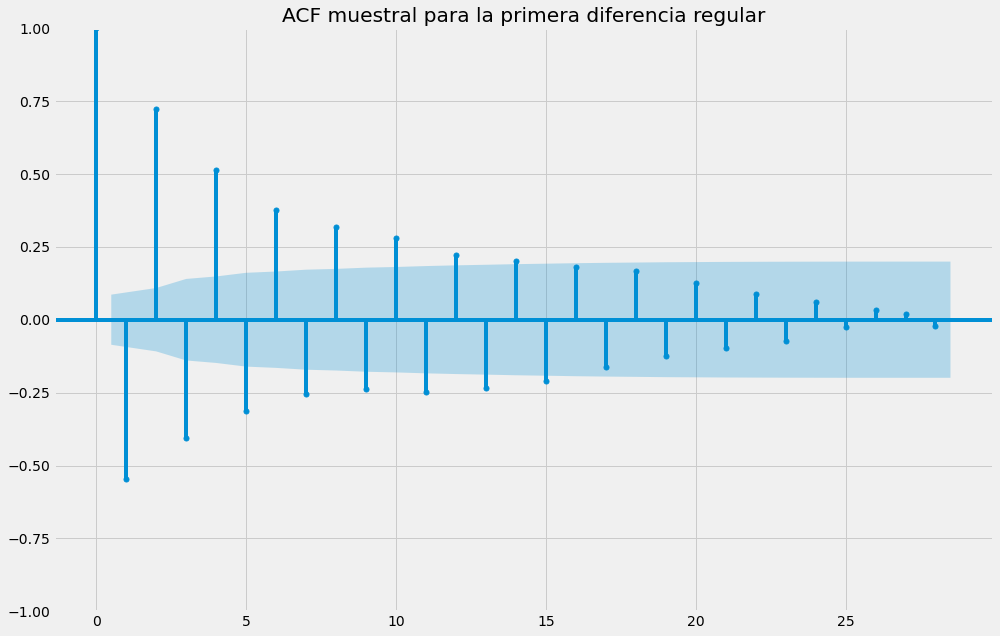

In [47]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st2d1[1:],
              title = "ACF muestral para la primera diferencia regular")
# Nótese que se toma los valores de la serie de tiempo diferenciada a partir de la segunda observación,
# ya que para la primera no se puede obtener su diferencia.

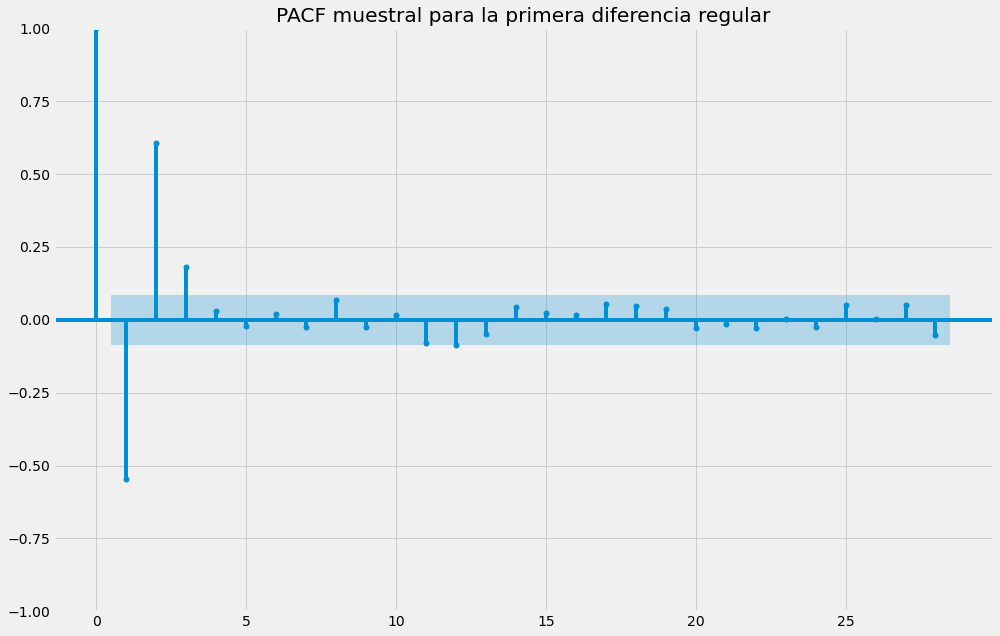

In [48]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st2d1[1:], method = 'ywm',
               title = "PACF muestral para la primera diferencia regular")

Se tiene que la ACF toma valores no significativos rápidamente (de acuerdo con las barras de *Bartlett*), es decir, para rezagos pequeños, lo que muestra que la serie es ergódica, cumplimiendo pues los tres requisitos básicos que debe cumplir una serie de tiempo para poder ser etiquetada como *estacionaria en sentido débil*. Así, es apropiado determinar los órdenes $p$ y $q$.

Se comienza, pues, considerando que la ACF tiene un patrón de cola exponencial amortiguada, mientras que la PACF exhibe un patrón tipo corte, lo cual implica que la serie diferenciada se debería modelar con un $AR(p)$, donde $p = 3$, ya que $\phi_{33}$ es el último valor de la PACF significativo y previo a un decaimiento abrupto. Con esto, se llega a que un modelo a considerar inicialmente es un $ARIMA(3, \ 1, \ 0)$.

# <center><font size="5"><font color='blue'>Punto cuatro</font></center>

Aplique varios modelos, explicando por qué aplica cada uno, y usar un criterio de selección para seleccionar el mejor. Sacar conclusiones argumentando cada una.
 
Sea $Y_t$ el valor de la serie de tiempo en un momento $t$. Para poder proceder con la estimación de los parámetros asociados a los modelos $ARIMA(p, \ d, \ q)$ que serán propuestos a continuación, entonces se van a 'resetear' los índices de la serie temporal en *Python*.

In [49]:
st2.reset_index(inplace = True)
st2.index = pd.DatetimeIndex(st2.date).to_period('D')
st2

,date,value
date,,
2020-01-01,2020-01-01,-0.89
2020-01-02,2020-01-02,-0.99
2020-01-03,2020-01-03,-1.62
2020-01-04,2020-01-04,-1.13
2020-01-05,2020-01-05,-0.91
...,...,...
2021-05-31,2021-05-31,-92.78
2021-06-01,2021-06-01,-91.90
2021-06-02,2021-06-02,-92.96


### Modelo uno. $ARIMA(3, \ 1, \ 0)$

El primer modelo que se va a considerar es un $ARIMA(3, 1, 0)$, ya que anteriormente se encontró que la serie de tiempo diferenciada una vez se puede modelar mediante un $AR(3)$. Así, la ecuación del modelo es:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [50]:
mod21 = ARIMA(st2.value, order = (3, 1, 0)).fit()
mod21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  521
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -730.725
Date:                Tue, 04 Oct 2022   AIC                           1469.450
Time:                        14:57:59   BIC                           1486.466
Sample:                    01-01-2020   HQIC                          1476.116
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3155      0.049     -6.463      0.000      -0.411      -0.220
ar.L2          0.6594      0.035     18.585      0.000       0.590       0.729
ar.L3          0.1889      0.047      4.058      0.000       0.098       0.280
sigma2         0.9703      0.054     17.910      0.000       0.864       1.077
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 7.11
Prob(Q):                              0.73   Prob(JB):                         0.03
Heteroskedasticity (H):               0.98   Skew:                            -0.17
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo dos. $ARIMA(2, \ 1, \ 0)$

Algún sujeto podría argumentar que el valor de $\hat{phi}_{33}$ se reduce de forma considerable en comparación con el valor de $\hat{\phi}_{22}$, por lo que la serie temporal con su primera diferencia se podría modelar mediante un $AR(2)$, llegando pues a un modelo $ARIMA(2, \ 1, \ 0)$. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2)(1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [51]:
mod22 = ARIMA(st2.value, order = (2, 1, 0)).fit()
mod22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  521
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -740.204
Date:                Tue, 04 Oct 2022   AIC                           1486.407
Time:                        14:57:59   BIC                           1499.169
Sample:                    01-01-2020   HQIC                          1491.407
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1974      0.037     -5.314      0.000      -0.270      -0.125
ar.L2          0.6218      0.035     17.715      0.000       0.553       0.691
sigma2         1.0066      0.057     17.658      0.000       0.895       1.118
===================================================================================
Ljung-Box (L1) (Q):                   8.91   Jarque-Bera (JB):                 4.76
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               1.03   Skew:                            -0.14
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo tres. $ARMA(3, \ 0)$

Si bien se mostró que para el modelamiento de esta serie temporal con modelos $ARIMA$ es necesario tomar la diferencia de la serie, se va a ensayar con un modelo $ARMA(3, \ 0)$, es decir, un modelo que ignora la primera diferencia y que toma el valor de $p = 3$ ya que la ACF tiene un patrón tipo cola (no amortiguada) y la PACF tiene un patrón tipo corte con $k = 3$, ya que $\hat{\phi}_{33}$ es el último valor de la PACF muestral que se puede considerar significativo y a continuación, en $\hat{\phi}_{44}$, hay una reducción abrupta. La ecuación de este modelo es:

$(1- \phi_1 B - \phi_2 B^2) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [52]:
mod23 = ARIMA(st2.value, order = (3, 0, 0)).fit()
mod23.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  521
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -745.371
Date:                Tue, 04 Oct 2022   AIC                           1500.742
Time:                        14:57:59   BIC                           1522.021
Sample:                    01-01-2020   HQIC                          1509.077
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.0732     45.332     -0.950      0.342    -131.923      45.777
ar.L1          0.8025      0.037     21.436      0.000       0.729       0.876
ar.L2          0.8191      0.035     23.570      0.000       0.751       0.887
ar.L3         -0.6220      0.035    -17.655      0.000      -0.691      -0.553
sigma2         1.0063      0.057     17.569      0.000       0.894       1.119
===================================================================================
Ljung-Box (L1) (Q):                   8.84   Jarque-Bera (JB):                 4.86
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               1.03   Skew:                            -0.14
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Nótese que por la naturaleza no estacionaria de la serie de tiempo sin considerar ninguna diferencia, el módulo **```statsmodels```*** arroja una advertencia, indicando lo mal que podría resultar este modelo para ajustar la serie de tiempo ***datos2***.

### Modelo cuatro. $ARIMA(3, \ 1, \ 1)$

El modelo que a priori se puede considerar el mejor es el primero, y como se puede ver, se trata de un modelo autorregresivo para la serie temporal con su primera diferencia regular. Así, se van a considerar dos modelos $ARIMA$ con $q \neq 0$, y en este caso se toma el valor de $q = 1$, para evaluar si tal vez este modelo puede ajustar mejor la serie temporal. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = (1 + \theta_1 B) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [53]:
mod24 = ARIMA(st2.value, order = (3, 1, 1)).fit()
mod24.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  521
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -730.407
Date:                Tue, 04 Oct 2022   AIC                           1470.813
Time:                        14:57:59   BIC                           1492.082
Sample:                    01-01-2020   HQIC                          1479.145
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1496      0.231     -0.648      0.517      -0.602       0.303
ar.L2          0.6922      0.053     13.083      0.000       0.589       0.796
ar.L3          0.0860      0.156      0.552      0.581      -0.219       0.391
ma.L1         -0.1725      0.233     -0.741      0.459      -0.629       0.284
sigma2         0.9691      0.054     17.887      0.000       0.863       1.075
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.29
Prob(Q):                              0.86   Prob(JB):                         0.03
Heteroskedasticity (H):               0.97   Skew:                            -0.17
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo cinco. $ARIMA(3, \ 1, \ 2)$

El modelo que a priori se puede considerar el mejor es el primero, y como se puede ver, se trata de un modelo autorregresivo para la serie temporal con su primera diferencia regular. Así, se van a considerar dos modelos $ARIMA$ con $q \neq 0$, y en este caso se toma el valor de $q = 2$, para evaluar si tal vez este modelo puede ajustar mejor la serie temporal. La ecuación de este modelo es la siguiente:

$(1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3)(1-B) Y_t = (1 + \theta_1 B + \theta_2 B^2) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [54]:
mod25 = ARIMA(st2.value, order = (3, 1, 2)).fit()
mod25.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  521
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -730.395
Date:                Tue, 04 Oct 2022   AIC                           1472.789
Time:                        14:57:59   BIC                           1498.312
Sample:                    01-01-2020   HQIC                          1482.788
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0086      1.516     -0.006      0.995      -2.980       2.963
ar.L2          0.6935      0.061     11.280      0.000       0.573       0.814
ar.L3         -0.0154      1.087     -0.014      0.989      -2.145       2.114
ma.L1         -0.3136      1.517     -0.207      0.836      -3.287       2.660
ma.L2          0.0453      0.448      0.101      0.920      -0.833       0.923
sigma2         0.9691      0.054     17.875      0.000       0.863       1.075
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.32
Prob(Q):                              0.86   Prob(JB):                         0.03
Heteroskedasticity (H):               0.97   Skew:                            -0.17
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Resumen de resultados

Ahora, basados en la calidad de los ajustes realizados por los cinco modelos presentados, se va a determinar cuál modelo es más adecuado basados en las métricas asociadas al ajuste, las cuales se presentan en la siguiente tabla:

|Modelo|Logverosimilitud|AIC|BIC|
|------|----------------|---|---|
| Uno | -730.725 | <span style="background-color: #FFFF00">**1469.450**</span> | <span style="background-color: #FFFF00">**1486.466**</span> |
| Dos | -740.204 | 1486.407 | 1499.169 |
| Tres | -745.371 | 1500.742 | 1522.021 |
| Cuatro | -730.407 | 1470.813 | 1492.082 | 
| Cinco | <span style="background-color: #FFFF00">**-730.395**</span> | 1472.789 | 1498.312 |

Como se observa, el modelo que maximiza la logverosimilitud es el modelo ***cinco***, si bien los modelos ***cuatro*** y ***uno*** tienen valores de logverosimilitud similares. En cambio, tanto para los criterios de información de Akaike y Bayesiano, estos son minimizados por el modelo ***uno***, y lo consigue, en el caso del BIC, con una diferencia de más de cinco unidades respecto al siguiente que es el modelo ***cuatro***. De esta forma, el modelo que se va a considerar como el mejor basados en estas métricas es el modelo ***uno***.

Así las cosas, el modelo que se va a emplear en adelante es el que se muestra en la siguiente ecuación:

$$(1 + 0.3155 B - 0.6594 B ^2 - 0.1889 B ^3)(1 - B) Y_t = w_t$$

# <center><font size="5"><font color='blue'>Punto cinco</font></center>
    
Verificar si el mejor modelo seleccionado en el numeral cuatro es estacionario e invertible.

Es importante recordar inicialmente que, de acuerdo con la teoría de las serie de tiempo y los modelos $ARIMA$, los modelos $AR(p)$ siempre son invertibles y los modelos $MA(q)$ son siempre, por su parte, estacionarios. Así las cosas, teniendo en cuenta que el modelo ***uno*** se puede considerar como un $AR(3)$ para la serie temporal a la que se le toma la primera diferencia regular, entonces se puede afirmar que este cumple con la condición de ser **invertible**, quedando pendiente verificar si el modelo ajustado es estacionario. Para ello, se debe cumplir que el módulo de las raíces de $\phi_3 (B)$ estén por fuera del círculo unitario. Observar pues que:

$$\hat{\phi}_3 (B) = 1 + 0.3155 B - 0.6594 B ^2 - 0.1889 B ^3$$

Para el cálculo de las ráices y sus módulos se emplean las funciones ```abs``` y ```np.roots``` de *Python*.

In [55]:
coefs21 = [-0.1889, -0.6594, 0.3155, 1]
modulos21 = abs(np.roots(coefs11))
modulos21

array([1.6294354 , 1.21358354, 1.21358354])

In [56]:
modulos11 > 1

array([ True,  True,  True])

Como se puede ver, las tres raíces del polinomio $\hat{\phi}_3 (B)$ son mayores que uno, por lo que se cumple que este modelo no solo es invertible, sino que también es estacionario. Ahora bien, esto último se puede chequear gráficamente observando los gráficos diagnósticos que entrega *Python*.

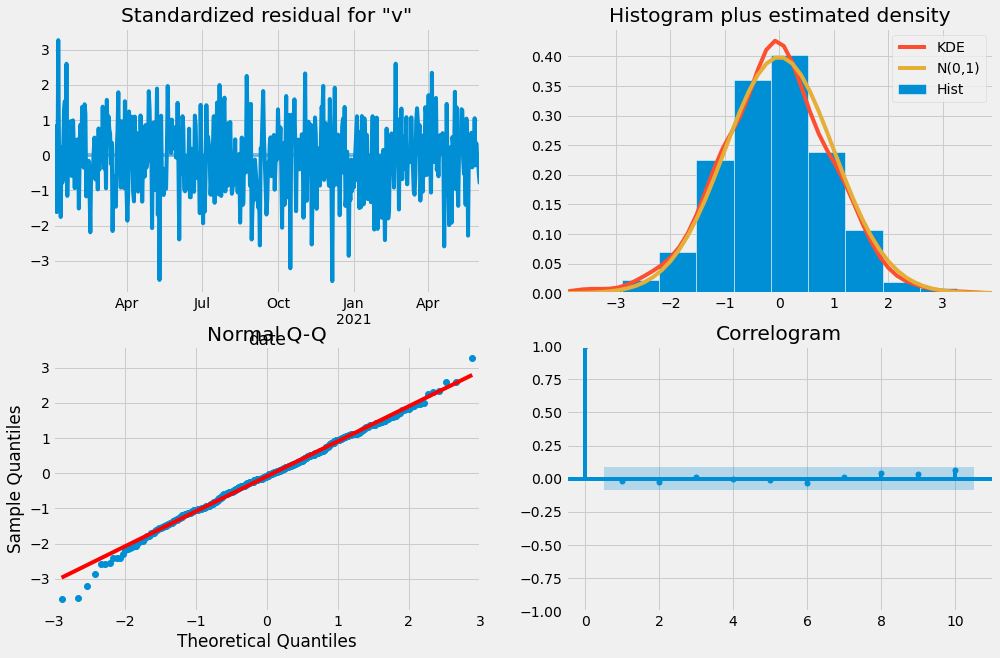

In [57]:
f3 = mod21.plot_diagnostics(figsize = (15, 10))

Como se puede observar en el gráfico de la primera fila a la izquierda, los residuales oscilan alrededor de cero, por lo que se puede decir que son estacionarios en covarianza. Asimismo, se observa que dichas oscilaciones se dan en un rango homogéneo (entre dos y dos negativo aproximadamente), lo que evidencia gráficamente que se puede cumplir el supuesto de homocedasticidad. Luego, pasando al gráfico de la primera fila a la derecha, se tiene que los residuales se distribuye alrededor de cero y que son mesocúrticos, lo cual se refleja en la semejanza que tiene la línea de densidad empírica (KDE) con la de una distribución normal con media cero y varianza uno (N(0, 1)), respaldando los supuestos de media nula y homocedasticidad que se discutieron antes.

Por último, se tiene que en la gráfica de la derecha de la segunda fila, que es la ACF para los residuales, se puede considerar que los residuales son ergódicos. Esto se discutirá con más detalles en el siguiente numeral, y así, se tiene que se puede pensar que los errores son estacionarios en sentido débil, corroborando lo que se mostró recientemente de forma analítica con los módulos de las raíces del polinomio $\hat{\phi}_3 (B)$.

# <center><font size="5"><font color='blue'>Punto seis</font></center>
    
Verificar si existe autocorrelación en los residuales del modelo usando el gráfico ACF y con la prueba de Ljung-Box para los diez primeros rezagos.

### Gráfico de la ACF para los residuales del modelo uno

A continuación se va a realizar el valor de los residuales así:

$$\hat{w}_t = Y_t - \hat{Y}_t, \ \ \ t = 1, \ 2, \ \dots, 231$$

In [58]:
# Cálculo de los residuales

residuales21 = st2.value - mod21.fittedvalues
residuales21

date
2020-01-01   -0.890000
2020-01-02   -0.100001
2020-01-03   -0.682374
2020-01-04    0.427448
2020-01-05    0.808895
                ...   
2021-05-31    0.004818
2021-06-01    0.034408
2021-06-02   -0.508893
2021-06-03   -0.772977
2021-06-04   -0.747360
Freq: D, Length: 521, dtype: float64

Y con esto se puede proceder con la construcción del gráfico de la ACF de estos residuales

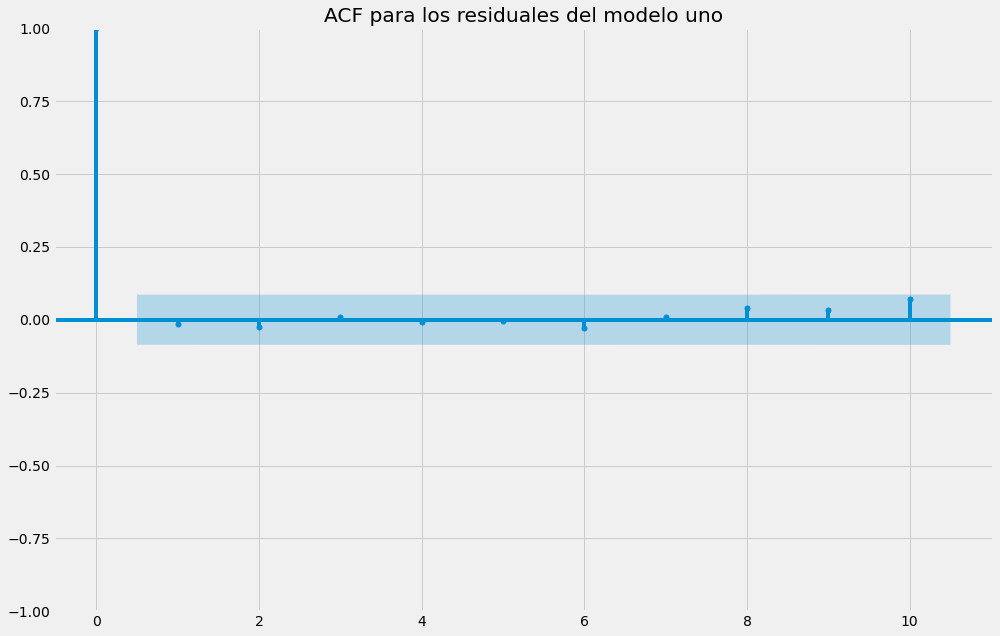

In [59]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     f2 = plot_acf(residuales21, lags = 10, title = "ACF para los residuales del modelo uno")

Como se puede observar, los $\hat{\rho} (k), \  k = 1, \ \dots, \ 10$ no superan las barras de *Bartlett*, por lo que se consideran no significativos. Esto es positivo en el sentido que no aportan sospechas sobre problemas de autocorrelación con los residuales, teniendo en cuenta que se asume que los errores son un ruido blanco, lo cual implica que son incorrelacionados entre sí. Ahora bien, se procederá a verificar esto con un test.

### Test de Ljung-Box

Sea $\rho (k) = Corr(w_t, \ w_{t+k})$. Con el test de Ljung-Box se puede verificar que los errores estén incorrelacionados a través de los residuales del modelo ***uno***, para lo cual se tienen las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \rho(1) = \rho(2) = \cdots = \rho(m) = 0 \\
        H_1: \ \exists \ k \ | \ \rho(k) \neq 0, \ k = 6, 12, 18, 24, 30, 36
\end{cases}
$$

La estadística de prueba para este test es $Q_{LB} = n \times (n+2) \sum_{k = 1}^m \frac{[\hat{\rho} (k)]^2}{239 - k}$, donde $n = 231$ en este caso y se tiene que bajo la hipótesis nula $Q_{LB} \ \sim \ \chi^2 (m)$. Para este test es posible obtener un valor p como: $V_p = \mathbb{Pr} [\chi^2 (m) > Q_{LB} ]$. Así:

In [60]:
sm.stats.acorr_ljungbox(residuales11,
                        lags = [6, 9, 12, 18, 24, 30, 36],
                        return_df = True)

,lb_stat,lb_pvalue
6,4.308090,0.635060
9,5.082444,0.827063
12,7.860799,0.795912
18,11.293854,0.881473
24,14.811524,0.926153
30,31.586809,0.386987
36,39.353079,0.322183


Nótese pues que de acuerdo con el test de Ljung-Box para rezagos correspondientes a los primeros seis múltiplos de seis, en todos ellos sucede que $V_p > \alpha = 0.05$. Con esto, se concluye que hay evidencia muestral suficiente para sugerir que los errores son incorrelacionados. Para normalidad, como se chequeará a continuación, esto implica que los errores son independientes entre sí.

Es importante notar que el test de Ljung-Box concuerda con el análisis gráfico de la función de autocorrelación muestral. Además, en el resumen que entrega *Python* cuando se encuentra el modelo, se da $V_p = 0.73 > 0.05$, concordando con lo calculado de forma 'manual' con la función ```acorr_ljungbox``` para los diferentes valores $m$ especificados antes.

# <center><font size="5"><font color='blue'>Punto siete</font></center>

Verificar si hay normalidad en los residuales del modelo. Sacar conclusiones argumentando cada una de ellas.
    
Se supuso, cuando se ajustaron los distintos modelos, que los errores del modelo son un ruido blanco gaussiano, por lo que ahora se procederá a verificar con ayuda de los residuales si se puede considerar estadísticamente que los errores, en efecto, son normales. Así pues, se consideran las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \text{Los errores se distribuyen siguiendo una normal} \\
        H_1: \ \text{Los errores no se distribuyen siguiendo una normal}
\end{cases}
$$

Para esto, se van a usar los tests analíticos de Kolmogorov-Smirnov (ya que $n = 521 > 50$) y de Jaque-Bera con un nivel de significancia de $\alpha = 0.05$, así como análisis gráficos. Así, comenzando con el test KS:

In [61]:
kstest(residuales21, 'norm')

KstestResult(statistic=0.05387358677384679, pvalue=0.09368492939954665)

In [62]:
kstest(mod21.resid, 'norm')

KstestResult(statistic=0.05387358677384679, pvalue=0.09368492939954665)

Nótese que el valor p de la prueba es $V_p = 0.09 > 0.05 = \alpha$, por lo que hay evidencia muestral suficiente para sugerir que los errores se distribuyen siguiendo una normal, con un nivel de significancia del cinco por ciento. De igual forma, con el resumen entregado por *Python*, se obtiene que el valor p del test JB es $V_p = 0.03 < \alpha$, concluyendo en este caso que **no** hay evidencia muestral suficiente para sugerir que los residuales se distribuyen siguiendo una normal. 

Como se puede ver, estos resultados son contradictorios, ya que con el test KS se acepta la normalidad, pero con el test JB se tiene el caso contrario. Para dirmir esta situación, se puede apelar a la prueba gráfica, y para ello, se debe observar el gráfico del numeral cinco, en la segunda fila a la izquierda, se tiene un gráfico cuantil-cuantil para los residuales, y en dicha figura se encuentra que los residuales no tienen desviaciones significativas respecto a los cuantiles teóricos, en general, porque en el extremo izquierdo se ve una pequeña desviación, lo cual permitiría pensar que los residuales tienen una distribución ligeramente asimétrica, pero esto no es marcado, por lo que es razonable considerar que los residuales siguen una distribución normal. Además, en ese mismo pánel pero en la primera fila a la derecha, se observa que hay una buena aproximación de la distribución normal (N(0, 1)) con la densidad ajustada para los residuales, por lo que gráficamente se tiene evidencia favorable al supuesto de normalidad, respaldando el test KS.

# <center><font size="5"><font color='blue'>Punto ocho</font></center>
    
Si todo lo anterior se cumple, entonces se puede realizar pronósticos con el 'mejor' modelo ajustado para los cinco valores futuros. Sacar conclusiones argumentando cada una.
    
Para el ajuste de modelos autorregresivos integrados de medias móviles se supone que los errores estructurales son un ruido blanco gaussiano, lo cual implica que estos son independientes e idénticamente distribuidos siguiendo una normal de media cero y varianza constante. Así pues, se encontró que para el modelo uno, un $ARIMA(3, \ 1, \ 0)$, los errores son un proceso estacionario en convarianza, independientes y se distribuye siguiendo una normal alrededor de cero, por lo que su media en efecto es nula y a su vez son homocedásticos. Además, como el modelo es un $AR(3)$ para la primera diferencia regular, este es invertible y por tanto es adecuado realizar predicciones con este modelo, y así mismo, se encontró que se cumple el supuesto de estacionariedad en covarianza.

Con esto, se procede a obtener estimaciones puntuales y con intervalos de confianza al 95 % para los siguientes cinco días.

In [63]:
pronostico21 = mod21.get_prediction(start = '2021-06-05',
                                    end = '2021-06-09',
                                    dynamic = False)
pron_puntual21 = pronostico21.predicted_mean
pron_ci21 = pronostico21.conf_int(alpha = 0.05) 
estims21 = pd.concat([pron_ci21, pron_puntual21], axis = 1)
est21 = estims21.rename(columns = {"lower value": "IC, extremo inferior",
                           "upper value": "IC, extremo superior",
                           "predicted_mean": "Estimación puntual"})
round(est21, 2)

,"IC, extremo inferior","IC, extremo superior",Estimación puntual
2021-06-05,-95.97,-92.11,-94.04
2021-06-06,-97.28,-92.61,-94.94
2021-06-07,-98.40,-91.13,-94.77
2021-06-08,-99.68,-91.08,-95.38
2021-06-09,-100.66,-89.83,-95.24


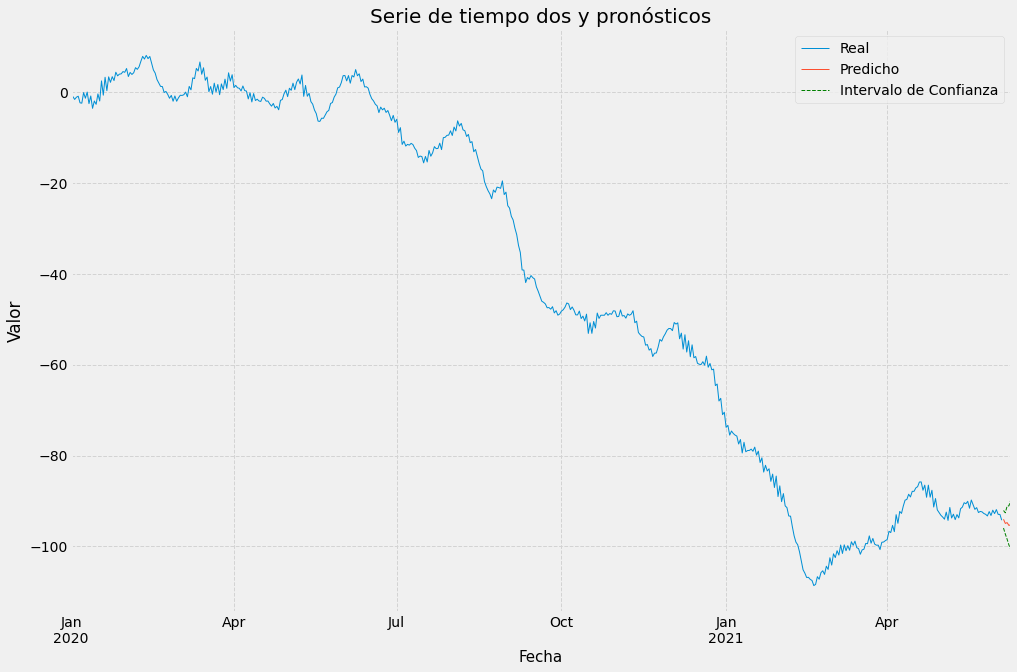

In [64]:
plt.figure(figsize=(15, 10))  #  Graficamos:
st2.value.plot(linewidth = 1)
plt.title("Serie de tiempo dos y pronósticos", fontsize = 20)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Valor')
pronostico21.predicted_mean.plot(linewidth = 1)
pron_ci21.iloc[:,0].plot(color="green", linestyle = '--', linewidth = 1)
pron_ci21.iloc[:,1].plot(color="green", linestyle = '--', linewidth = 1)
plt.legend(["Real", "Predicho", "Intervalo de Confianza"])
plt.grid(color = 'lightgray', linestyle = '--')

# <center><font size="10"><font color='red'>Serie de tiempo tres</font></center>

A continuación se presenta la solución de los ejercicios propuestos para la **serie de tiempo tres**. Así, se inicia realizando la lectura de los datos que se encuentran en la hoja denominada como *"tercera"* en el libro de Excel que contiene todos los datos que se van a emplear para este parcial. Para ello se va a comenzar leyendo los datos. Es importante tener en cuenta que estos se encuentran en una carpeta llamada **"Datos"**. A continuación, se realizará algunos chequeos básicos que permitan tener seguridad en cuanto a la correcta lectura de los datos.


In [65]:
st3 = pd.read_excel('../Datos/datos_parcial2.xlsx',
                    sheet_name = 'tercera',
                    parse_dates = ["dia"])
st3.shape

(837, 2)

Esta base de datos contiene $837$ observaciones y $2$ columnas. Esto coincide con los registros que se tienen en el Excel. Luego, chequeando las primeras y las últimas quince observaciones de la base de datos:

In [66]:
st3.head(15)

,dia,registro
0,2020-03-07,-54.21
1,2019-07-24,26.12
2,2020-07-10,-16.74
3,2019-06-19,-1.54
4,2019-04-01,-1.67
5,2020-09-16,-37.96
6,2019-02-25,4.65
7,2020-01-08,-47.63
8,2020-01-15,-60.47
9,2019-10-27,33.32


In [67]:
st3.tail(15)

,dia,registro
822,2019-01-13,16.44
823,2020-05-17,-41.12
824,2020-01-13,-58.14
825,2020-04-24,-52.51
826,2019-03-27,-10.71
827,2020-11-20,-38.82
828,2019-08-27,35.88
829,2020-12-09,-41.58
830,2019-05-27,-17.44
831,2020-02-26,-43.52


Como se observa, la base de datos está desordenada, siendo pues necesario organizarla de forma ascendente según la fecha, esto es: primero deben aparecer los registros más antiguos y hacia el final los más recientes.

In [68]:
st3.sort_values(by = "dia", inplace = True)
st3.head(15)

,dia,registro
484,2019-01-01,1.37
661,2019-01-02,3.65
753,2019-01-03,5.86
211,2019-01-04,10.57
441,2019-01-05,14.17
341,2019-01-06,16.51
327,2019-01-07,20.11
353,2019-01-08,22.89
567,2019-01-09,23.89
319,2019-01-10,23.30


In [69]:
st3.tail(15)

,dia,registro
491,2021-04-02,-66.79
334,2021-04-03,-65.37
22,2021-04-04,-65.36
419,2021-04-05,-65.91
177,2021-04-06,-65.90
185,2021-04-07,-67.41
510,2021-04-08,-67.65
668,2021-04-09,-67.58
547,2021-04-10,-67.13
589,2021-04-11,-64.04


Y en este caso no parece haber problemas asociados con el ordenamiento de los datos, encontrando pues que las observaciones arrancan el primer de enero de 2019 y finalizan el 16 de abril de 2021. Es importante notar que entre estas dos fechas se tienen 837 días incluyendo los extremos, por lo que se puede pensar que se tiene un registro por día en la base de datos. Se procederá a chequear esto:

In [70]:
len(st3.dia.unique())

837

En efecto, se tienen registros para 837 días distintos, por lo que se confirma, pues, que se tiene un registro por día y que no hay registros faltantes entre las dos fechas dadas. Ahora se procederá a tomar los días como los índices de esta base de datos.

In [71]:
st3.set_index("dia", inplace = True)
st3.head()

,registro
dia,
2019-01-01,1.37
2019-01-02,3.65
2019-01-03,5.86
2019-01-04,10.57
2019-01-05,14.17


# <center><font size="5"><font color='blue'>Punto uno</font></center>
    
Realice los gráficos ACF y PACF para tratar de identificar los órdenes $p$, $d$ y $q$ del modelo $ARIMA(p, \ d, \ q)$. Saque conclusiones argumentando cada una.

Se va comenzar graficando la serie como tal y su ACF y PACF para identificar si la serie tiene componente estructural de tendencial, lo cual implicaría que se debe comenzar realizando una diferenciación para a continuación proceder adecuadamente con la identificación de los órdenes $p$ y $q$.

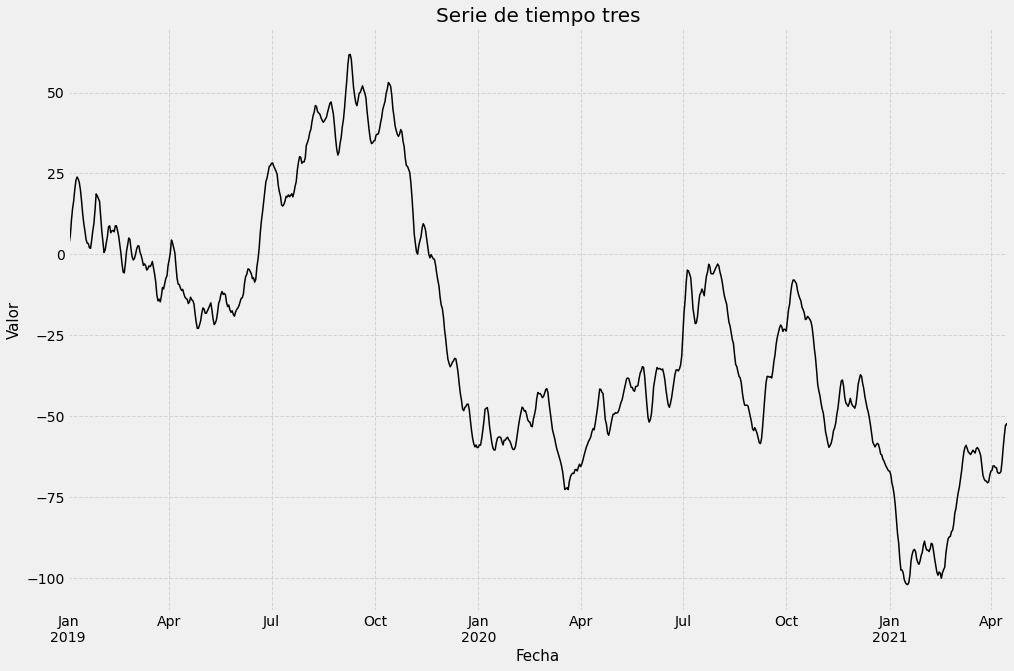

In [72]:
f1 = st3.plot(color = 'black',
              figsize = (15, 10),
              linewidth = 1.5)
plt.xlabel("Fecha", fontsize = 15)
plt.ylabel("Valor", fontsize = 15)
plt.title("Serie de tiempo tres", fontsize = 20)
f1.get_legend().remove()
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

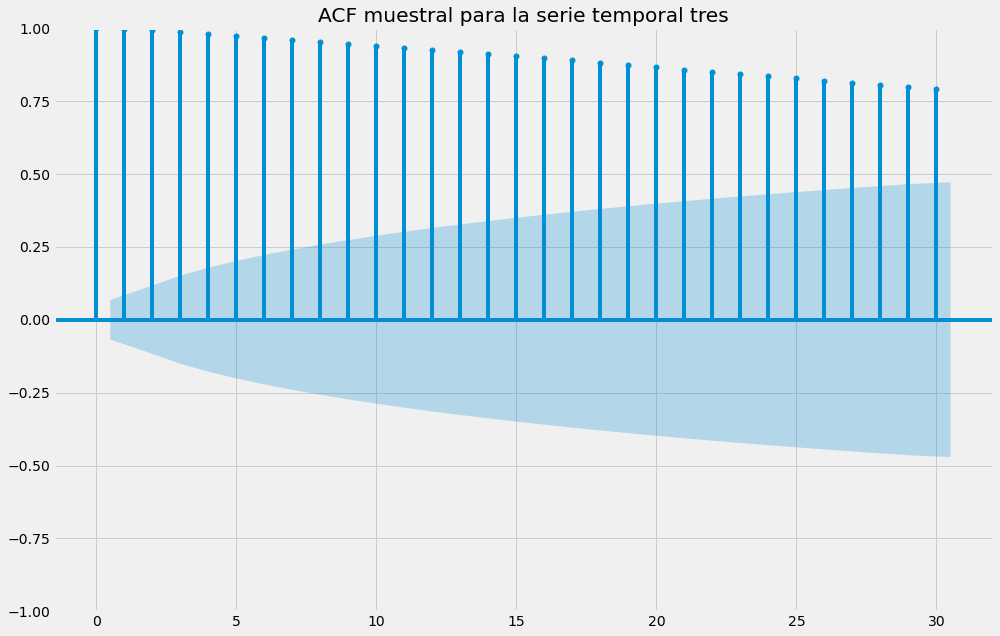

In [73]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st3,
              title = "ACF muestral para la serie temporal tres")

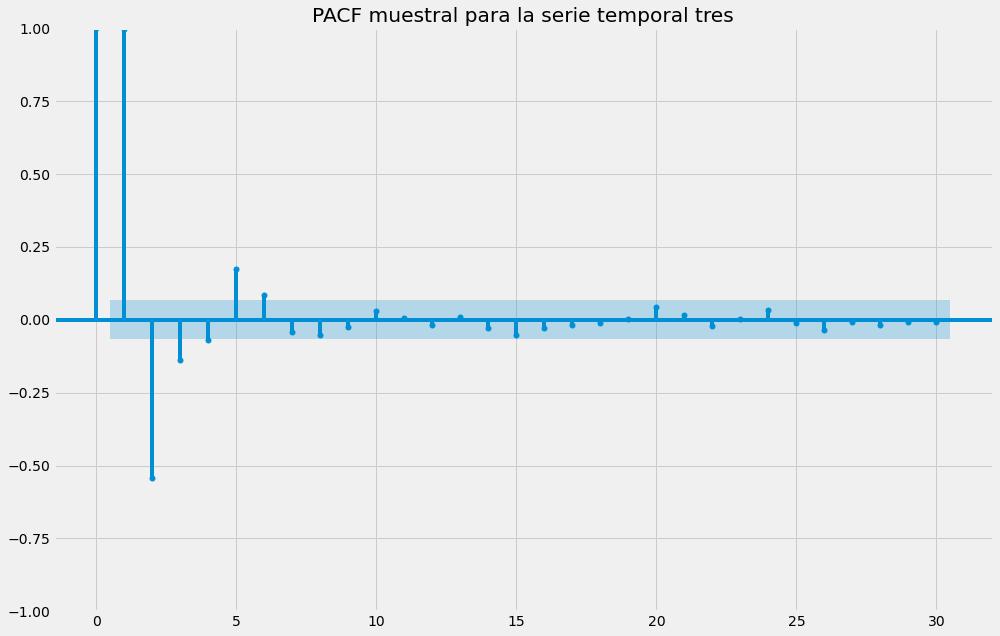

In [74]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st3, method = 'ywm',
               title = "PACF muestral para la serie temporal tres")

A partir de los gráficos anteriores, vale la pena comenzar mencionado que la serie de tiempo **no es estacionaria**, ya que su media no es constante, reflejándose esto en una tendencia negativa junto con algunos ciclos de crecimiento. Esta no estacionariedad se refleja, pues, en el gráfico de la ACF muestral, ya que tiene un patrón de cola positiva no amortiguada, lo que significa que las autocorrelaciones decaen muy lentamente a medida que el rezago aumenta, lo cual indica que no se cumple la propiedad de ergodicidad que deben tener las series temporales estacionarias en sentido débil, y por tanto, se debe diferenciar la serie, de forma que $d \geq 1$.

No obstante, la varianza de la serie temporal parece ser constante, lo cual hace innecesaria la introducción de logaritmos u otra clase de transformaciones para estabilizarla.

En cuanto a la PACF, esta podría pensarse como de tipo cola exponencial amortiguada, ya que esta tiene un patrón de cola que toma valores tanto positivos como negativos y que en la mayoría de los casos va tomando valores más pequeños respecto al rezago previo. Sin embargo, varias personas podrían argumentar que se trata de un patrón tipo corte con $k = 6$, ya que este rezago es el último significativo y a contiuación se da una reducción fuerte del valor de la autocorrelación parcial respecto a los primeros valores que toma esta función.

# <center><font size="5"><font color='blue'>Punto dos</font></center>
    
Aplicar la prueba de Dickey-Fuller para ver si es necesario tomar diferencias. Sacar conclusiones argumentando cada una.

A partir de los gráficos obtenidos en el punto anterior, se sospecha la presencia de raíces unitarias, haciendo invable de momento la selección de $p$ y $q$. Así pues, se va a verificar esto con un test de raíces unitarias de *Dickey-Fuller*, cuya **hipótesis nula** es que la serie tiene al menos una raíz unitaria y la **alternas** es que la serie no tiene raíces unitarias. Se usará un nivel de confianza de $\alpha = 0.05$. Estas hipótesis se pueden reexpresar como sigue:

$\left\lbrace\begin{array}{c}H_0: \phi = 1  \\ H_1: \phi < 1\end{array}\right. $ equivalentemente
$\left\lbrace\begin{array}{c} H_0: \textrm{El proceso no es estacionario} \\ H_1:\textrm{El proceso es estacionario.} \end{array}\right. $

In [75]:
# Cálculo del valor p asociado al test de Dickey-Fuller
adfuller(st3)[1]

0.5213338273526276

Con un valor p más grande que el nivel de significancia $\alpha$= 0.05, no hay evidencia muestral suficiente para rechazara la hipótesis nula, por lo que según el test de Dickey-Fuller, el proceso no es estacionario, lo cual es congruente con lo hallado en el gráfico de registro contra el tiempo. De esta forma, se confirma que es necesario considerar diferencias, es decir, es decir, al proponer modelos $ARIMA(p, \ d, \ q)$, se debe considerar $d \geq 1$. De este modo, al diferenciar una vez se obtiene lo siguiente: 


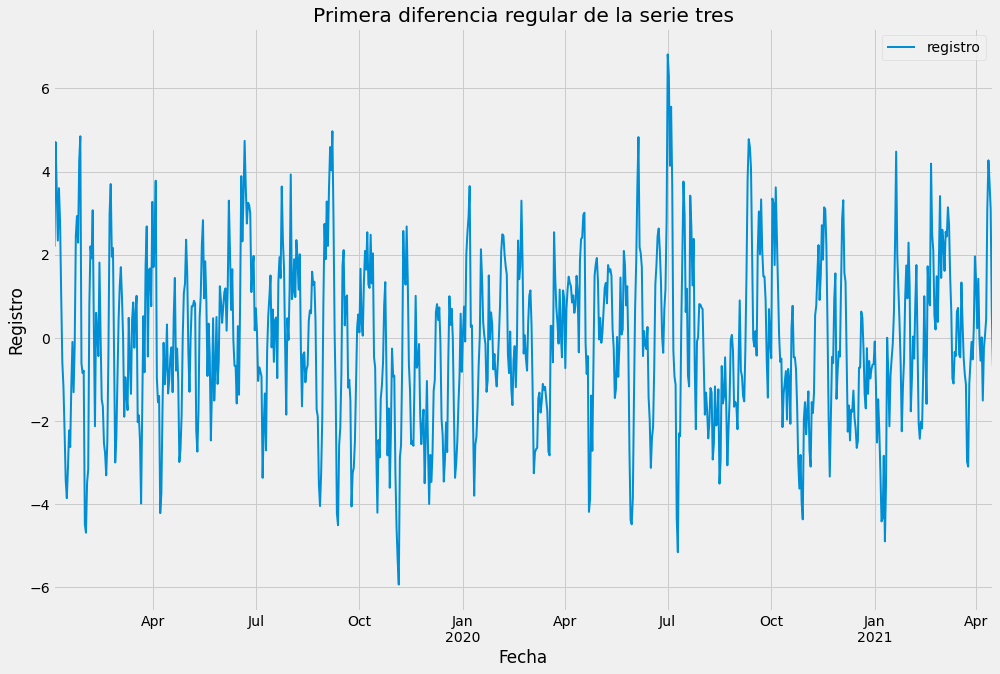

In [76]:
st3.diff().dropna().plot(figsize = (15, 10), linewidth = 2)
plt.title("Primera diferencia regular de la serie tres")
plt.xlabel("Fecha")
plt.ylabel("Registro")
plt.show()

A partir del gráfico de la serie diferenciada, es razonable pensar que la serie puede ser estacionaria, ya que tiene media cero y su varianza es constante, además que no se presentan ciclos o rachas de signos positivos y negativos, quedando pues pendiente de verificar mediante la ACF y la PACF si se cumple la propiedad de ergodicidad que tienen las series estacionarias en covarianza (como se verificará en el siguiente punto). Ahora bien, para poder comprobar si la serie de tiempo es adecuada ahora para su modelamiento a través de un $ARIMA(p, \ d, \ q)$, se aplicará de nuevo un ***test de raíces unitarias de Dickey-Fuler*** con un nivel de significancia de $\alpha = 0.05$.

In [77]:
adfuller(st3.diff().dropna().registro)[1]

1.0550731533336851e-07

Y se encuentra que $V_p \approx 1.06 \times 10 ^{-7} < 0.05 = \alpha$, lo que implica que la hipótesis nula debe ser rechazada. Así, no hay evidencia muestral suficiente para sugerir con un nivel de significancia del cinco por ciento que la serie tiene al menos una raíz unitaria. En la práctica, esto se interpreta como que la serie carece de raíces unitarias, y así se obtiene que la primera diferencia $d = 1$ es suficiente para poder modelar la serie.

# <center><font size="5"><font color='blue'>Punto tres</font></center>
    
Si $d \geq 1$ en el ítem $(2)$, entonces realizar de nuevo los gráficos ACF y PACF de la serie diferenciada de orden $d$ con el fin de identificar los órdenes $p$ y $q$. Sacar conclusiones argumentando cada una.

In [78]:
st3d1 = st3.diff()

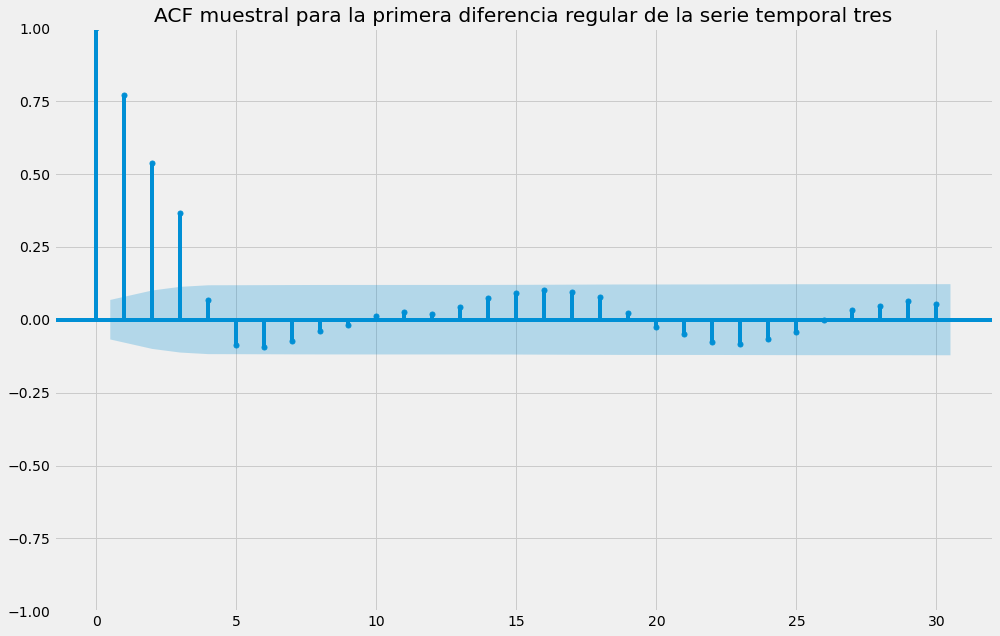

In [79]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_acf(st3d1[1:],
              title = "ACF muestral para la primera diferencia regular de la serie temporal tres")
# Nótese que se toma los valores de la serie de tiempo diferenciada a partir de la segunda observación,
# ya que para la primera no se puede obtener su diferencia.

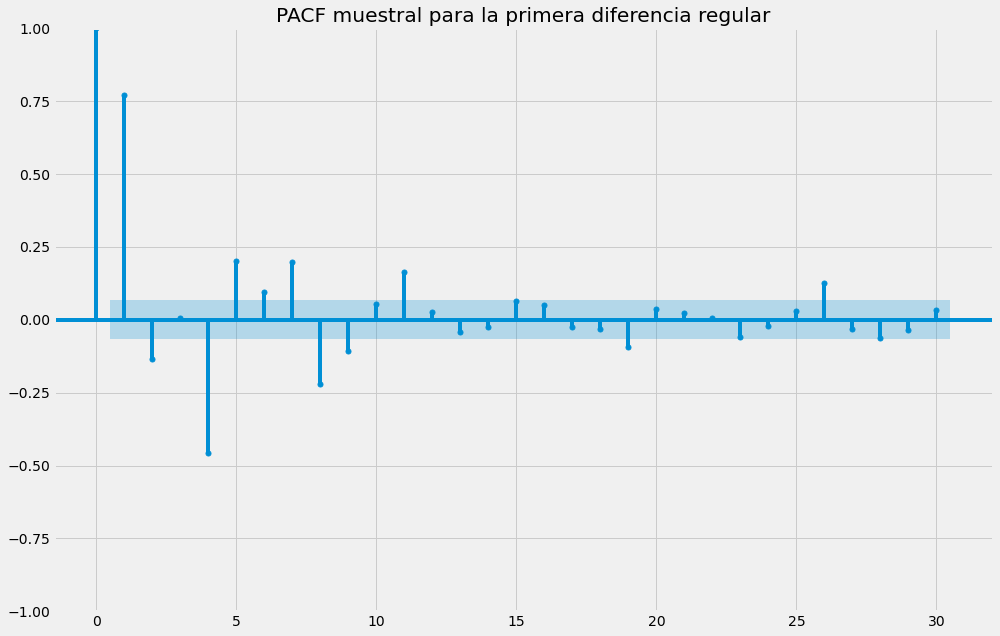

In [80]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     plot_pacf(st3d1[1:], method = 'ywm',
               title = "PACF muestral para la primera diferencia regular")

El patrón que siguen los $\hat{\rho}(k)$  es mucho más claro que el anterior. Se evidencia pues que la ACF tiene un patrón de decaimiento exponencial sinusoidal, y esto sucede cuando el polinomio $\phi_{p}(B)$ tiene al menos una raiz compleja por lo que $p$ debe ser mayor o igual a dos.

En cuanto al patrón de la PACF no es muy claro si es tipo corte o es tipo decaímiento exponencial, y no se puede ignorar que los valores de $\hat{\phi}_{kk}$ cambian de signo *"cíclicamente"*. Esto puede ser un indicio de que el verdadero patrón de la PACF es decaimiento exponencial, por lo que se podría proponer particularmente un decaimiento exponencial sinusoidal. De manera similar que para el polinomio $\phi_{p}(B)$, el polinomio $ϴ_{q}(B)$ debe tener al menos una raíz compleja, por lo que $q$ debe ser mayor o gual a dos, por lo que un modelo candidato es un $ARIMA(2, \ 1, \ 2)$. Por proponer otro modelo, se puede pensar que el patrón de la gráfica PACF es corte, con último corte diferente de cero en $k= 11$, pues a medida que el rezago aumenta, también lo hace la probabilidad de cometer error tipo I, así el segundo modelo candidato es $ARIMA(11,\ 1, \ 0)$; sin embargo, alguna persona podría argumentar que dado este mayor error tipo I para rezagos mayores, un modelo más apropiado y parsiomonio sería aquel que considera el corte en $k = 2$, por lo que el modelo en este caso sería un $ARIMA(3, 1, 0)$, ya que para $k = 3$ se presenta una autocorrelación parcial muestral muy próxima a cero.

Ahora bien, como se puede observar, el segundo modelo propuesto tendrá que estimar once parámetros para la parte autorregresiva, y podría haber algún error en la asunción del patrón tipo corte. En ese sentido, regresando al patrón cola-cola para las ACF y PACF muestrales, y ante la imposibilidad de seleccionar valores certeros para $p$ y $q$ a partir del análisis gráfico (solo se puede determinar que $p, q \geq 2$), vale la pena emplear una función de selección automática en *Python* como lo es el método ```auto_arima()``` del módulo **```pmdarima```**.

In [81]:
auto_arima(st3, start_p = 2, start_q = 2, d = 1, n_fits=50, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2670.101, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3531.329, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2780.302, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2861.621, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3530.218, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2703.951, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2671.689, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2667.555, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2662.944, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2768.500, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2540.527, Time=0.40 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2570.487, Time=0.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2536.497, Time=0.71 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2536.977, Time=0.36 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

ARIMA(order=(5, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

De esta forma, se observa que varios modelos son sugeridos, y de estos, van a modelarse también un $ARIMA(5, \ 1, \ 2)$, un $ARIMA(4, \ 1, \ 2)$ y un $ARIMA(4, \ 1, \ 4)$. Nótese que no fueron consideradosd aquellos modelos que tenían AIC y BIC muy altos en comparación con el resto o que no cumpliesen con la condición de que $p, q \geq 2$. Es decir, se considerarán un total de seis modelos.

# <center><font size="5"><font color='blue'>Punto cuatro</font></center>

Aplique varios modelos, explicando por qué aplica cada uno, y usar un criterio de selección para seleccionar el mejor. Sacar conclusiones argumentando cada una.
 
Sea $Y_t$ el valor de la serie de tiempo en un momento $t$. Para poder proceder con la estimación de los parámetros asociados a los modelos $ARIMA(p, \ d, \ q)$ que serán propuestos a continuación, entonces se van a 'resetear' los índices de la serie temporal en *Python*.

In [82]:
st3.reset_index(inplace = True)
st3.reset_index(inplace = True)
st3.index = pd.DatetimeIndex(st3.dia).to_period('D')
st3

,index,dia,registro
dia,,,
2019-01-01,0,2019-01-01,1.37
2019-01-02,1,2019-01-02,3.65
2019-01-03,2,2019-01-03,5.86
2019-01-04,3,2019-01-04,10.57
2019-01-05,4,2019-01-05,14.17
...,...,...,...
2021-04-12,832,2021-04-12,-59.77
2021-04-13,833,2021-04-13,-56.04
2021-04-14,834,2021-04-14,-52.95


### Modelo uno. $ARIMA(2, \ 1, \ 2)$

Como se mostró antes, se deberían considerar valores de $p, q$ para la primera diferencia regular de la serie temporal tales que $p, q \geq 2$, por lo que es razonable emplezar considerando este modelo que resulta siendo el más marsimonio de todos. Con esto, se tiene que la ecuación de este modelo viene dada por:

$(1- \phi_1 B - \phi_2 B^2)(1-B) Y_t = (1 + \theta_1 B + \theta_2 B^2)w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [83]:
mod31 = ARIMA(st3.registro, order = (2, 1, 2)).fit()
mod31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1329.102
Date:                Tue, 04 Oct 2022   AIC                           2668.204
Time:                        14:58:11   BIC                           2691.848
Sample:                    01-01-2019   HQIC                          2677.268
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2926      0.119      2.468      0.014       0.060       0.525
ar.L2          0.3289      0.066      5.007      0.000       0.200       0.458
ma.L1          0.7372      0.125      5.891      0.000       0.492       0.982
ma.L2         -0.0945      0.088     -1.080      0.280      -0.266       0.077
sigma2         1.4049      0.067     21.015      0.000       1.274       1.536
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.72   Prob(JB):                         0.63
Heteroskedasticity (H):               0.80   Skew:                             0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo dos. $ARIMA(11, \ 1, \ 0)$

Como se explicó antes, alguien podría considerar que el patrón de la PACF de la primera diferencia regular de la serie de tiempo tres es de tipo corte con $k = 11$.

$\left( 1- \sum_{p=1}^{11} \phi_p B^p \right) (1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [84]:
mod32 = ARIMA(st3.registro, order = (11, 1, 0)).fit()
mod32.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                ARIMA(11, 1, 0)   Log Likelihood               -1198.822
Date:                Tue, 04 Oct 2022   AIC                           2421.645
Time:                        14:58:11   BIC                           2478.388
Sample:                    01-01-2019   HQIC                          2443.398
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9546      0.037     25.546      0.000       0.881       1.028
ar.L2         -0.1966      0.050     -3.898      0.000      -0.295      -0.098
ar.L3          0.5530      0.046     11.923      0.000       0.462       0.644
ar.L4         -0.8828      0.051    -17.178      0.000      -0.983      -0.782
ar.L5          0.1821      0.060      3.044      0.002       0.065       0.299
ar.L6         -0.0767      0.059     -1.294      0.196      -0.193       0.039
ar.L7          0.4974      0.058      8.634      0.000       0.384       0.610
ar.L8         -0.1951      0.051     -3.823      0.000      -0.295      -0.095
ar.L9         -0.1283      0.048     -2.683      0.007      -0.222      -0.035
ar.L10        -0.1093      0.048     -2.262      0.024      -0.204      -0.015
ar.L11         0.1710      0.034      5.033      0.000       0.104       0.238
sigma2         1.0264      0.047     21.741      0.000       0.934       1.119
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.03
Prob(Q):                              0.86   Prob(JB):                         0.03
Heteroskedasticity (H):               0.88   Skew:                             0.14
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo tres. $ARIMA(3, \ 1, \ 0)$

Como se explicó antes, alguien podría considerar que el patrón de la PACF de la primera diferencia regular de la serie de tiempo tres es de tipo corte, con $k = 3$.

$\left( 1- \phi_1 B - \phi_2 B^2 - \phi_3 B^3 \right) (1-B) Y_t = w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [85]:
mod34 = ARIMA(st3.registro, order = (3, 1, 0)).fit()
mod34.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1379.315
Date:                Tue, 04 Oct 2022   AIC                           2766.630
Time:                        14:58:11   BIC                           2785.545
Sample:                    01-01-2019   HQIC                          2773.881
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8772      0.037     23.682      0.000       0.805       0.950
ar.L2         -0.1438      0.051     -2.830      0.005      -0.243      -0.044
ar.L3          0.0085      0.037      0.227      0.820      -0.065       0.082
sigma2         1.5853      0.073     21.738      0.000       1.442       1.728
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.09
Prob(Q):                              0.91   Prob(JB):                         0.21
Heteroskedasticity (H):               0.77   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo cuatro. $ARIMA(5, \ 1, \ 2)$

Modelo propuesto con un método de selección automático.

$\left( 1- \sum_{p=1}^{5} \phi_p B^p \right) (1-B) Y_t = (1 + \theta_1 B + \theta_2 B^2) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [86]:
mod34 = ARIMA(st3.registro, order = (5, 1, 2)).fit()
mod34.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1259.569
Date:                Tue, 04 Oct 2022   AIC                           2535.137
Time:                        14:58:12   BIC                           2572.966
Sample:                    01-01-2019   HQIC                          2549.639
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0703      0.362      0.194      0.846      -0.639       0.779
ar.L2          0.4165      0.171      2.432      0.015       0.081       0.752
ar.L3          0.3388      0.073      4.638      0.000       0.196       0.482
ar.L4         -0.2516      0.121     -2.075      0.038      -0.489      -0.014
ar.L5         -0.2505      0.156     -1.603      0.109      -0.557       0.056
ma.L1          0.9146      0.366      2.501      0.012       0.198       1.631
ma.L2          0.1158      0.207      0.559      0.576      -0.291       0.522
sigma2         1.1887      0.056     21.170      0.000       1.079       1.299
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.85   Prob(JB):                         0.55
Heteroskedasticity (H):               0.95   Skew:                            -0.04
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo cinco. $ARIMA(4, \ 1, \ 2)$

Modelo propuesto con un método de selección automático.

$\left( 1- \sum_{p=1}^{11} \phi_p B^p \right) (1-B) Y_t = (1 + \theta_1 B + \theta_2 B^2) w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [87]:
mod51 = ARIMA(st3.registro, order = (4, 1, 2)).fit()
mod51.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1262.769
Date:                Tue, 04 Oct 2022   AIC                           2539.539
Time:                        14:58:12   BIC                           2572.639
Sample:                    01-01-2019   HQIC                          2552.228
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5525      0.076      7.276      0.000       0.404       0.701
ar.L2          0.1318      0.055      2.388      0.017       0.024       0.240
ar.L3          0.3107      0.054      5.750      0.000       0.205       0.417
ar.L4         -0.4426      0.033    -13.426      0.000      -0.507      -0.378
ma.L1          0.4424      0.082      5.425      0.000       0.283       0.602
ma.L2         -0.0680      0.079     -0.863      0.388      -0.222       0.086
sigma2         1.1979      0.057     21.136      0.000       1.087       1.309
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.83   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                            -0.06
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo seis. $ARIMA(4, \ 1, \ 4)$


Modelo propuesto con un método de selección automático.

$\left( 1- \sum_{p=1}^{4} \phi_p B^p \right) (1-B) Y_t = \left( 1 + \sum_{q=1}^{4} \theta_q B^q \right)w_t, \ w_t~un~R.B. \sim N(0, \sigma^2)$

In [88]:
mod36 = ARIMA(st3.registro, order = (4, 1, 4)).fit()
mod36.summary()

C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               registro   No. Observations:                  837
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1176.782
Date:                Tue, 04 Oct 2022   AIC                           2371.564
Time:                        14:58:14   BIC                           2414.122
Sample:                    01-01-2019   HQIC                          2387.879
                         - 04-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1101      0.221      0.499      0.618      -0.322       0.543
ar.L2         -0.0518      0.141     -0.368      0.713      -0.328       0.224
ar.L3          0.0685      0.087      0.792      0.429      -0.101       0.238
ar.L4         -0.0623      0.060     -1.040      0.298      -0.180       0.055
ma.L1          0.8206      0.216      3.798      0.000       0.397       1.244
ma.L2          0.7031      0.068     10.326      0.000       0.570       0.837
ma.L3          1.0441      0.116      9.001      0.000       0.817       1.271
ma.L4          0.4566      0.172      2.652      0.008       0.119       0.794
sigma2         0.9723      0.046     21.244      0.000       0.883       1.062
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.86
Prob(Q):                              0.88   Prob(JB):                         0.05
Heteroskedasticity (H):               0.89   Skew:                             0.14
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Resumen de resultados

Ahora, basados en la calidad de los ajustes realizados por los cinco modelos presentados, se va a determinar cuál modelo es más adecuado basados en las métricas asociadas al ajuste, las cuales se presentan en la siguiente tabla:

|Modelo|Logverosimilitud|AIC|BIC|
|------|----------------|---|---|
| Uno | -1329.102 | 2668.204 | 2691.848 |
| Dos | <span style="background-color: #80ff00">-1198.822</span> | <span style="background-color: #80ff00">2421.645</span> | <span style="background-color: #80ff00">2478.388</span> | 
| Tres | -1379.315 | 2766.630 | 2785.545 |
| Cuatro | -1259.569 | 2535.137 | 2572.966 |
| Cinco |-1262.769 | 2539.539 | 2572.639 | 
| Seis | <span style="background-color: #FFFF00">-1176.782</span> | <span style="background-color: #FFFF00">2371.564</span> | <span style="background-color: #FFFF00">2414.122</span> |


Como se puede observar en la tabla anterior, el modelo ***seis*** es el que maximiza la logverosimilitud y el que minimiza tanto al AIC como al BIC, por lo que puede resultar adecuado para poder modelar la serie de tiempo entregada. No obstante, como se observa en la salida de *Python*, se tiene una advertencia que está ligada a la convergencia de los algoritmos empleados para poder obtener las estimaciones $\hat{\phi}_p$ y $\hat{\theta}_q$, por lo que podrían resultar estimadores poco creíbles. En este orden de ideas, resulta adecuado considerar al siguiente modelo que maximiza la logverosimilitud y minimiza al AIC y al BIC, que resulta siendo el modelo ***dos***. Alguien podría argumentar que este modelo está considerando una gran cantidad de parámetros en comparación con los otros modelos. No obstante, es importante tener en cuenta que se tienen más de 800 datos y el modelo consta de 11 parámetros, por lo que no se cae en una sobreparametrización del modelo. No obstante, al revisar la significancia de los parámetros estimados, se encuentra que todos los parámetros excepto $\hat{\phi}_6$ no son significativos, por lo que surge la idea de considerar un modelo $ARIMA(6, \ 1, \ 0)$, pero esto puede resultar contradictorio en relación a la gráfica de la PACF de la primera diferencia regular de la serie, por lo que se conservará el modelo $ARIMA(11, \ 1, \ 0)$.

Teniendo presente lo anterior, la ecuación del modelo ajustado es:

$$( 1- 0.9546 B + 0.1966 B ^ 2 - 0.5530 B^3  + 0.8828 B^4 - 0.1821 B^5 + 0.0767 B^6 - 0.4974 B^7 \\  +0.1951 B^8 + 0.1283 B^9 +0.1093 B^{10} - 0.1710 B^{11}) (1-B) \hat{Y}_t = w_t$$

# <center><font size="5"><font color='blue'>Punto cinco</font></center>
    
Verificar si el mejor modelo seleccionado en el numeral cuatro es estacionario e invertible.

Es importante recordar inicialmente que, de acuerdo con la teoría de las serie de tiempo y los modelos $ARIMA$, los modelos $AR(p)$ siempre son invertibles y los modelos $MA(q)$ son siempre, por su parte, estacionarios. Así las cosas, teniendo en cuenta que el modelo ***dos*** se puede considerar como un $AR(11)$ para la serie temporal a la que se le toma la primera diferencia regular, entonces se puede afirmar que este cumple con la condición de ser **invertible**, quedando pendiente verificar si el modelo ajustado es estacionario. Para ello, se debe cumplir que el módulo de las raíces de $\phi_{11} (B)$ estén por fuera del círculo unitario. Observar pues que:

$$\hat{\phi}_{11} (B) = 1- 0.9546 B + 0.1966 B ^ 2 - 0.5530 B^3  + 0.8828 B^4 - 0.1821 B^5 + 0.0767 B^6 - 0.4974 B^7 \\  +0.1951 B^8 + 0.1283 B^9 +0.1093 B^{10} - 0.1710 B^{11}$$

Para el cálculo de las ráices y sus módulos se emplean las funciones ```abs``` y ```np.roots``` de *Python*.

In [89]:
coefs32= [-0.171, 0.1093, 0.1283, 0.1951, -0.4974, 0.0767, -0.1821, 0.8828, -0.553, 0.1966, -0.9546, 1]
modulos32= abs(np.roots(coefs32))
modulos32

array([1.31189408, 1.31189408, 1.18472581, 1.18472581, 1.1144516 ,
       1.1144516 , 1.12630685, 1.12630685, 1.17054022, 1.14570871,
       1.14570871])

Y verificando si son mayores que uno:

In [90]:
modulos32 > 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

En efecto, todos ellos son mayores que uno, por lo que se concluye que el modelo propuesto es estacionario. Al chequear esto con los diagnósticos gráficos que tiene *Python*, entonces:

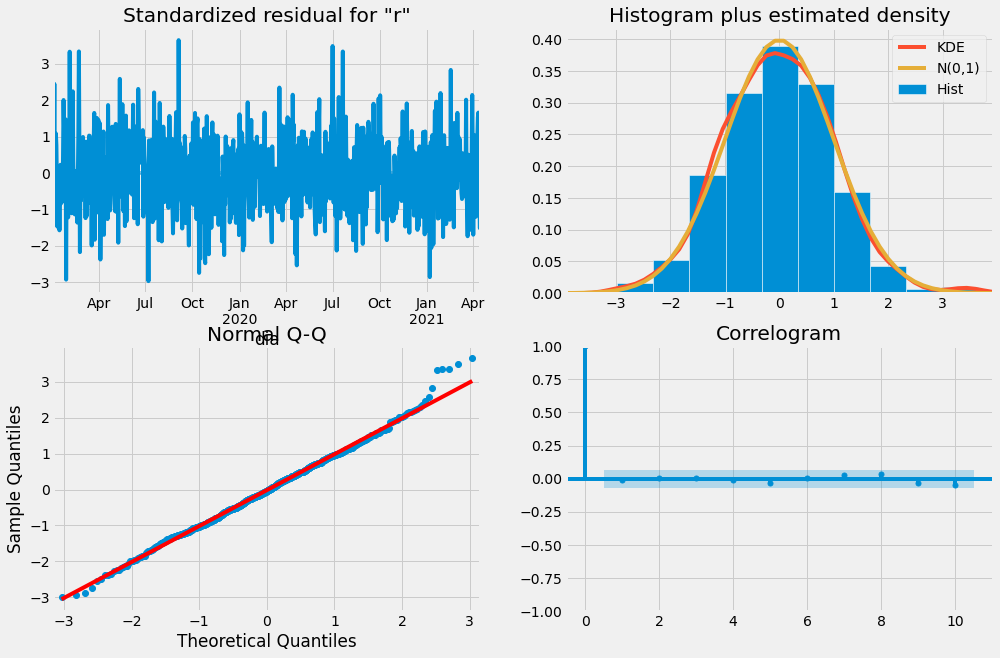

In [91]:
f3 = mod32.plot_diagnostics(figsize = (15, 10))

Como se puede observar en el gráfico de la primera fila a la izquierda, los residuales oscilan alrededor de cero, por lo que se puede decir que son estacionarios en covarianza. Asimismo, se observa que dichas oscilaciones se dan en un rango homogéneo (entre dos y dos negativo aproximadamente con algunas desviaciones adicionales en algunos casos), lo que evidencia gráficamente que se puede cumplir el supuesto de homocedasticidad. Luego, pasando al gráfico de la primera fila a la derecha, se tiene que los residuales se distribuye alrededor de cero y que son mesocúrticos, lo cual se refleja en la semejanza que tiene la línea de densidad empírica (KDE) con la de una distribución normal con media cero y varianza uno (N(0, 1)), respaldando los supuestos de media nula y homocedasticidad que se discutieron antes.

Por último, se tiene que en la gráfica de la derecha de la segunda fila, que es la ACF para los residuales, se puede considerar que los residuales son ergódicos. Esto se discutirá con más detalles en el siguiente numeral, y así, se tiene que se puede pensar que los errores son estacionarios en sentido débil, corroborando lo que se mostró recientemente de forma analítica con los módulos de las raíces del polinomio $\hat{\phi}_{11} (B)$.

# <center><font size="5"><font color='blue'>Punto seis</font></center>
    
Verificar si existe autocorrelación en los residuales del modelo usando el gráfico ACF y con la prueba de Ljung-Box para los diez primeros rezagos.

### Gráfico de la ACF para los residuales del modelo uno

A continuación se va a realizar el valor de los residuales así:

$$\hat{w}_t = Y_t - \hat{Y}_t, \ \ \ t = 1, \ 2, \ \dots, 231$$

In [92]:
# Cálculo de los residuales

residuales32 = st3.registro - mod32.fittedvalues
residuales32

dia
2019-01-01    1.370000
2019-01-02    2.279996
2019-01-03    0.452485
2019-01-04    3.086057
2019-01-05   -0.234124
                ...   
2021-04-12    1.680802
2021-04-13    0.007279
2021-04-14   -0.532972
2021-04-15   -1.542143
2021-04-16    0.324144
Freq: D, Length: 837, dtype: float64

Y con esto se puede proceder con la construcción del gráfico de la ACF de estos residuales.

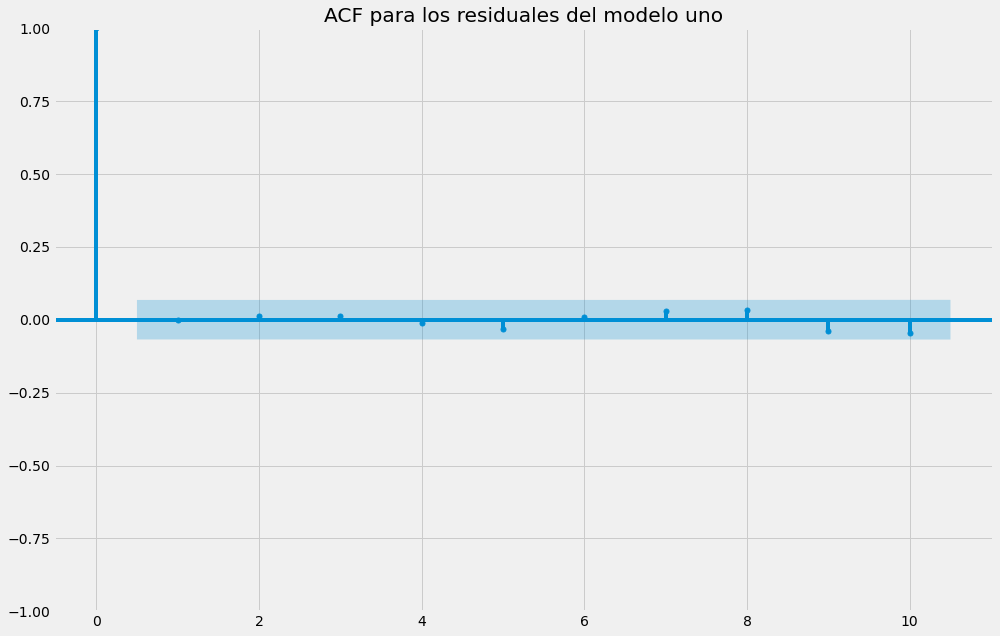

In [93]:
with plt.rc_context():
     plt.rc("figure", figsize=(15, 10))
     f2 = plot_acf(residuales32, lags = 10, title = "ACF para los residuales del modelo uno")

Como se puede observar, los $\hat{\rho} (k), \  k = 1, \ \dots, \ 10$ no superan las barras de *Bartlett*, por lo que se consideran no significativos. Esto es positivo en el sentido que no aportan sospechas sobre problemas de autocorrelación con los residuales, teniendo en cuenta que se asume que los errores son un ruido blanco, lo cual implica que son incorrelacionados entre sí. Ahora bien, se procederá a verificar esto con un test.

### Test de Ljung-Box

Sea $\rho (k) = Corr(w_t, \ w_{t+k})$. Con el test de Ljung-Box se puede verificar que los errores estén incorrelacionados a través de los residuales del modelo ***uno***, para lo cual se tienen las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \rho(1) = \rho(2) = \cdots = \rho(m) = 0 \\
        H_1: \ \exists \ k \ | \ \rho(k) \neq 0, \ k = 6, 12, 18, 24, 30, 36
\end{cases}
$$

La estadística de prueba para este test es $Q_{LB} = n \times (n+2) \sum_{k = 1}^m \frac{[\hat{\rho} (k)]^2}{239 - k}$, donde $n = 231$ en este caso y se tiene que bajo la hipótesis nula $Q_{LB} \ \sim \ \chi^2 (m)$. Para este test es posible obtener un valor p como: $V_p = \mathbb{Pr} [\chi^2 (m) > Q_{LB} ]$. Así:

In [94]:
sm.stats.acorr_ljungbox(residuales32,
                        lags = [6, 9, 12, 18, 24, 30, 36],
                        return_df = True)

,lb_stat,lb_pvalue
6,1.230225,0.975365
9,3.998225,0.911529
12,11.014956,0.527637
18,25.115238,0.121775
24,28.200685,0.251666
30,32.936765,0.325293
36,38.606356,0.352620


Nótese pues que de acuerdo con el test de Ljung-Box para rezagos correspondientes a los primeros seis múltiplos de seis, en todos ellos sucede que $V_p > \alpha = 0.05$. Con esto, se concluye que hay evidencia muestral suficiente para sugerir que los errores son incorrelacionados. Para normalidad, como se chequeará a continuación, esto implica que los errores son independientes entre sí.

Es importante notar que el test de Ljung-Box concuerda con el análisis gráfico de la función de autocorrelación muestral. Además, en el resumen que entrega *Python* cuando se encuentra el modelo, se da $V_p = 0.86 > 0.05$, concordando con lo calculado de forma 'manual' con la función ```acorr_ljungbox``` para los diferentes valores $m$ especificados antes.

# <center><font size="5"><font color='blue'>Punto siete</font></center>

Verificar si hay normalidad en los residuales del modelo. Sacar conclusiones argumentando cada una de ellas.

Se supuso, cuando se ajustaron los distintos modelos, que los errores del modelo son un ruido blanco gaussiano, por lo que ahora se procederá a verificar con ayuda de los residuales si se puede considerar estadísticamente que los errores, en efecto, son normales. Así pues, se consideran las siguientes hipótesis:

$$
\begin{cases}
        H_0: \ \text{Los errores se distribuyen siguiendo una normal} \\
        H_1: \ \text{Los errores no se distribuyen siguiendo una normal}
\end{cases}
$$

Para esto, se van a usar los tests analíticos de Kolmogorov-Smirnov (ya que $n = 837 > 50$) y de Jaque-Bera con un nivel de significancia de $\alpha = 0.05$, así como análisis gráficos. Así, comenzando con el test KS:

In [95]:
kstest(residuales32, 'norm')

KstestResult(statistic=0.02072006353629441, pvalue=0.8574747498689508)

Nótese que el valor p de la prueba es $V_p = 0.86 > 0.05 = \alpha$, por lo que hay evidencia muestral suficiente para sugerir que los errores se distribuyen siguiendo una normal, con un nivel de significancia del cinco por ciento. De igual forma, con el resumen entregado por *Python*, se obtiene que el valor p del test JB es $V_p = 0.03 > \alpha$, por lo que se rechaza la hipótesis nula y se concluiría con un nivel de significancia del $ 5\% $ que los errores no siguen una distribución normal. Esto puede deberse al hecho que el test de Jaque-Bera estudia la asimetría de la distribución, y como se pudo ver en el gráfico cuantil-cuantil de la segunda fila a la izquierda que se mostró antes, los errores tienden a alejarse de la distribución ideal en la cola superior. Sin embargo, considerando esta gráfica, puede observar que tales desviaciones no son significativas, por lo que es adecuado conservar la conclusión de que los errores siguen una distribución normal.

# <center><font size="5"><font color='blue'>Punto ocho</font></center>
    
Si todo lo anterior se cumple, entonces se puede realizar pronósticos con el 'mejor' modelo ajustado para los cinco valores futuros. Sacar conclusiones argumentando cada una.

Para el ajuste de modelos autorregresivos integrados de medias móviles se supone que los errores estructurales son un ruido blanco gaussiano, lo cual implica que estos son independientes e idénticamente distribuidos siguiendo una normal de media cero y varianza constante. Así pues, se encontró que para el modelo uno, un $ARIMA(11, \ 1, \ 0)$, los errores son un proceso estacionario en convarianza, independientes y se distribuye siguiendo una normal alrededor de cero, por lo que su media en efecto es nula y a su vez son homocedásticos. Además, como el modelo es un $AR(11)$ para la primera diferencia regular, este es invertible y por tanto es adecuado realizar predicciones con este modelo, y así mismo, se encontró que se cumple el supuesto de estacionariedad en covarianza.

Con esto, se procede a obtener estimaciones puntuales y con intervalos de confianza al 95 % para los siguientes cinco días.

In [96]:
pronostico32 = mod32.get_prediction(start = '2021-04-17',
                                    end = '2021-04-21',
                                    dynamic = False)
pron_puntual32 = pronostico32.predicted_mean
pron_ci32= pronostico32.conf_int(alpha = 0.05) 
estims32 = pd.concat([pron_ci32, pron_puntual32], axis = 1)
est32 = estims32.rename(columns = {"lower registro": "IC, extremo inferior",
                           "upper registro": "IC, extremo superior",
                           "predicted_mean": "Estimación puntual"})
round(est32, 2)

,"IC, extremo inferior","IC, extremo superior",Estimación puntual
2021-04-17,-56.42,-52.45,-54.44
2021-04-18,-60.84,-52.12,-56.48
2021-04-19,-64.25,-50.52,-57.39
2021-04-20,-67.64,-47.48,-57.56
2021-04-21,-70.71,-44.49,-57.60


Gráficamente, se observa de la siguiente manera:

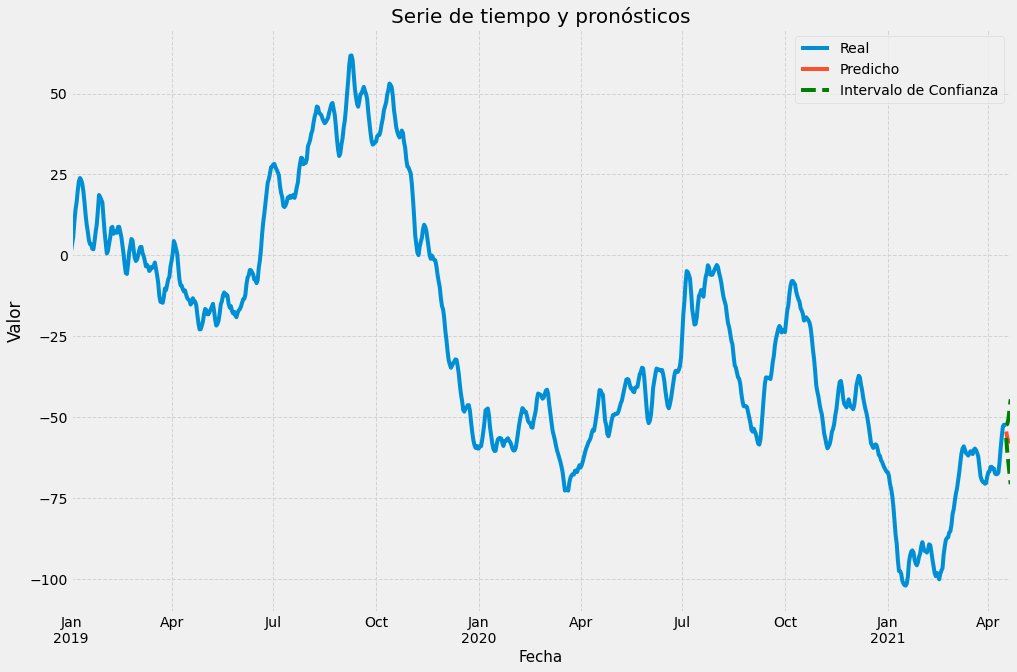

In [97]:
plt.figure(figsize=(15, 10))  #  Graficamos:
st3.registro.plot()
plt.title("Serie de tiempo y pronósticos", fontsize = 20)
plt.xlabel('Fecha', fontsize = 15)
plt.ylabel('Valor')
pronostico32.predicted_mean.plot()
pron_ci32.iloc[:,0].plot(color="green", linestyle = '--')
pron_ci32.iloc[:,1].plot(color="green", linestyle = '--')
plt.legend(["Real", "Predicho", "Intervalo de Confianza"])
plt.grid(color = 'lightgray', linestyle = '--')